# All Analysis

This notebooks aims at making All-encompasing Data Frame and Structures as well as Explore data on a more Inter-Subject Level

#### Create Giant Analysis DF: 

Get all of the Subject Data In one Giant DF: Having the Trial Num, SUbject Name, the MW estimate, All Pupil Estimates from both Eyes and Gaze Checks

In [66]:
import os 
import pandas as pd
import numpy as np


### Options
est = ''
partial = ''



currentANalysisName = "TEST_res100_dgv5_bll500_blb75_smw10_smL2000_swG50_trO10000_trB5000"

workingDir = os.getcwd();
import pickle

# Open the file in binary mode
with open(os.path.join(workingDir,currentANalysisName,'individuals','preprocessed.pickle'), 'rb') as file:
    
    # Call load method to deserialze
    allData = pickle.load(file)


### Create a Directory for Summary Statistics: 
statPath = (os.path.join(workingDir,currentANalysisName,'summary'))
os.makedirs(statPath, exist_ok=True)

### Open Final stat Log: 
log_file = open(os.path.join(statPath,"finalStatLog.txt"),'w+')


In [67]:
log_file = open(os.path.join(statPath,"finalStatLog.txt"),'w+')


def pad_columns(df: pd.DataFrame, depth: int, fill='') -> pd.DataFrame:
    """
    Ensure df.columns is a MultiIndex with exactly `depth` levels.
    Missing levels are right-padded with `fill`.
    """
    if not isinstance(df.columns, pd.MultiIndex):
        # single-level → promote to MultiIndex
        df.columns = pd.MultiIndex.from_tuples([(c,) + (fill,) * (depth - 1) for c in df.columns])
    elif df.columns.nlevels < depth:
        df.columns = pd.MultiIndex.from_tuples(
            [tuple(col) + (fill,) * (depth - len(col)) for col in df.columns]
        )
    return df


dfs = []
target_depth = 3  # we want every DataFrame to have 3 column levels

for i, ds in enumerate(allData):
    # --- pupilMW ----------------------------------------------------
    pupil = ds['pupilMW'].copy()
    pupil = pad_columns(pupil, target_depth)

    # Add ID columns **with the same depth**
    pupil[('DS', '', '')] = f'DS{i + 1}'
    pupil[('trialNum', '', '')] = np.arange(1, len(pupil) + 1)

    # --- storyIndCheck ---------------------------------------------
    story = allData[i]['checkInfo']['storyIndCheck'].copy()

    # Ensure the second level retains original column names
    story.columns = pd.MultiIndex.from_tuples(
        [('Checks', '' ,col) for col in story.columns]
    )
    story = pad_columns(story, target_depth)  # Promote to 3 levels

    # --- join for this participant ---------------------------------
    dfs.append(pd.concat([pupil, story], axis=1))

# Combine all participants into one big DataFrame
grand_df = pd.concat(dfs, axis=0, ignore_index=True)

# Remove spaces from all levels of MultiIndex column names
grand_df.columns = grand_df.columns.map(
    lambda col: tuple(c.replace(' ', '_') for c in col) if isinstance(col, tuple) else col
)


log_file.write(" "*15+"="*58 + "\n")
log_file.write(" "*15+"="*5+ " "*15+" FINAL STATISTICS LOG:"+ " "*15+"="*5+ " \n")
log_file.write(" "*15+"="*58 + "\n\n")
log_file.write("\n===# Descriptives #=== \n\n")
log_file.write(f"      N.Subjects                   {len(allData)}\n")
log_file.write(f"      N. Trials                    {len(np.unique(grand_df['trialNum']))}\n")
log_file.write(f"      Mean Good Data across Subj:  {grand_df['Checks']['']['goodRatioLeft'].mean():3.3f}\n")
log_file.write(f"      Tracked MW across Subj:      {grand_df[grand_df['Tracking']=='TRACKED']['MW_Estimate'].mean():3.3f} ({grand_df[grand_df['Tracking']=='TRACKED']['MW_Estimate'].std():3.3f})\n")
log_file.write(f"      Untracked MW across Subj:    {grand_df[grand_df['Tracking']=='UNTRACKED']['MW_Estimate'].mean():3.3f} ({grand_df[grand_df['Tracking']=='UNTRACKED']['MW_Estimate'].std():3.3f})\n")


import re

grand_df['DS'] = grand_df['DS'].str.replace(
    r'DS(\d+)',                       # grab the digits after “DS”
    lambda m: f'DS{int(m.group(1)):02d}',  # re-emit them with 2-digit zero-padding
    regex=True
)

grand_df.to_excel(os.path.join(statPath,"all_data.xlsx"))
grand_df

MW_Estimate GazeDifference Pupil_Diameter                           \
                                         Mean                      Std   
                                     Left_Eye    Right_Eye    Left_Eye   
0           0.0      49.387711     -44.863349  -249.454636  455.027527   
1           0.0      54.303658    -945.891439  -846.260326  364.305941   
2           0.0      47.306006    -526.523974  -621.954198  381.431308   
3           1.0      46.317740    -827.830151  -691.436894  304.946385   
4           1.0      54.489214            NaN          NaN         NaN   
..          ...            ...            ...          ...         ...   
595        39.0      16.799839   -1479.518200 -1396.909144  406.558142   
596        46.0      18.920339    -236.728519  -182.585644  160.824818   
597        31.0      31.213439    -552.690593  -384.793318  133.463322   
598        28.0      22.164042    -366.122276  -310.520427  237.288127   
599        15.0      16.345835    -667.046556  -581.677044  175.831079   

                                      Tracking    DS  ...        Checks  \
                     diff                             ...                 
      Right_Eye  Left_Eye Right_Eye                   ... goodRatioLeft   
0    435.906358  0.631072  0.465837    TRACKED  DS01  ...      0.966173   
1    389.999865  0.358777  0.238450  UNTRACKED  DS01  ...      0.878054   
2    377.165578 -0.194625 -0.174423    TRACKED  DS01  ...      0.897392   
3    328.477942  0.762147  0.716537  UNTRACKED  DS01  ...      0.924759   
4           NaN       NaN       NaN    TRACKED  DS01  ...      0.728923   
..          ...       ...       ...        ...   ...  ...           ...   
595  390.137713 -0.823867 -0.833433    TRACKED  DS15  ...      0.989717   
596  143.437954  0.134133  0.123533  UNTRACKED  DS15  ...      0.983411   
597  127.444009  0.175600  0.176867    TRACKED  DS15  ...      0.981913   
598  220.617470  0.569836  0.618567  UNTRACKED  DS15  ...      1.000000   
599  149.614391  0.134100  0.080133    TRACKED  DS15  ...      0.975748   

                                                                            \
                                                                             
    goodRatioRight goodPupRatioLeft goodPupRatioRight   gazeDiff  gazeRate   
0         0.966173         0.964036          0.964036  30.610695  0.049798   
1         0.878054         0.562438          0.562438  52.509016  0.071852   
2         0.897392         0.924076          0.924076  36.163686  0.094045   
3         0.924759         0.974026          0.974026  40.297689  0.078642   
4         0.728923         0.657343          0.657343  56.838691  0.103735   
..             ...              ...               ...        ...       ...   
595       0.989717         1.000000          1.000000  27.831183  0.014952   
596       0.983411         1.000000          1.000000  29.232701  0.028445   
597       0.981913         1.000000          1.000000  26.484281  0.022154   
598       1.000000         1.000000          1.000000  27.740794  0.016720   
599       0.975748         1.000000          1.000000  29.810338  0.022959   

                                                     
                                                     
    pupilDiff meanEyeDiff saccadeRate     blinkRate  
0    0.019558   44.397058    0.000002  6.813910e-07  
1    0.005309   22.410789    0.000003  1.035411e-06  
2    0.012378   25.122732    0.000003  9.598819e-07  
3    0.023348   21.939351    0.000002  8.466604e-07  
4    0.017194   28.367248    0.000003  9.650735e-07  
..        ...         ...         ...           ...  
595  0.054356   12.859047    0.000001  1.285622e-07  
596  0.052069   10.982120    0.000002  2.684236e-07  
597  0.050513   16.482705    0.000001  2.261420e-07  
598  0.044110   14.088896    0.000001  1.569507e-07  
599  0.048490    8.239553    0.000001  1.819284e-07  

[600 rows x 21 columns]

In [68]:

trackedEntities = []
## Setup Working Directory and all necessery paths
workingDir =  os.getcwd();
path = os.path.split(workingDir)[0] + "\\data" #data path
subjects = [f for f in os.listdir(path) if  not os.path.isfile(os.path.join(path, f))] # get all the filenames


for filename  in subjects:

    with open(os.path.join(path, filename,filename + '_log.txt'), 'r') as fp:
        for line in fp:
            if "Current Named Entity" in line:
                entityTracked = line.split("Current Named Entity: ")[1].strip()
                trackedEntities.append(entityTracked)

                break

trackedEntities

first_rows = grand_df.groupby('DS').first()
first_rows.replace({'TRACKED': 'Karolina', 'UNTRACKED': 'Janek'},inplace=True)


pd.DataFrame([list(first_rows['Tracking']),trackedEntities],columns=first_rows['Tracking'],index=['df','original'])

C:\Users\barak\AppData\Local\Temp\ipykernel_84584\2426126136.py:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  first_rows = grand_df.groupby('DS').first()


Tracking,Karolina,Karolina,Karolina,Janek,Janek,Karolina,Karolina,Janek,Karolina,Janek,Karolina,Janek,Karolina,Janek,Janek
df,Karolina,Karolina,Karolina,Janek,Janek,Karolina,Karolina,Janek,Karolina,Janek,Karolina,Janek,Karolina,Janek,Janek
original,KAROLINA,KAROLINA,KAROLINA,JANEK,JANEK,KAROLINA,KAROLINA,JANEK,KAROLINA,JANEK,KAROLINA,JANEK,KAROLINA,JANEK,JANEK


#### (OPTIONALS)

1. Z-score MW Estimate!: 
2. Choice of Relevant Subjects 
3. Choice of Relevant Trials 





In [70]:



## -- Joice of DS -- ##
dsToExclude = ['DS01']
grand_df = grand_df[~grand_df['DS'].isin(dsToExclude)]

## -- Joice of DS AND Trials --##
# A clvere use of Apply - which applies a function alongside an axis: tuple will
# construct our tuple out of values from both olumn thus making it easier to compare via isin() 
pairs_to_exclude = []
filtered_df = grand_df[~grand_df[['DS', 'trialNum']].apply(tuple, axis=1).isin(pairs_to_exclude)]


## --- Exclude based on mean MW --- ## 

# mean_check = grand_df[['MW_Estimate','DS']].groupby('DS').mean()['MW_Estimate'] > 10
# grand_df = grand_df[grand_df['DS'].isin(mean_check[mean_check].index)]
# grand_df

## -- Z score of MW Estimate -- 


### True and Nice!!!! Transforms a DataFrame BY GROUP but returns the original Data Frame! 
if est == 'zscore':
    grand_df['MW_Estimate'] = grand_df.groupby('DS')['MW_Estimate'].transform(
        lambda x: (x - x.mean()) / x.std() )


## --- Only Part of Trials -- ##
if partial == 'second':
    grand_df  = grand_df[(grand_df[('trialNum', '', '')] > 20) & (grand_df[('trialNum', '', '')] <= 40)]

elif partial =='first':
    grand_df  = grand_df[(grand_df[('trialNum', '', '')] <= 20)]



grand_df= grand_df.dropna()

In [71]:
np.unique(grand_df['trialNum'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])

## (1) GENERAL: Test Is Tracked Entity Different from Untracked Entity?

#### (1.1) Test Whether Pupil Diameter Differs between Tracked and Untracked Entity: 

We controll immediatley for SUBJECTS

so Making Basic Models:

        MW_estimate ~ Tracking +trialNum + (1|Subjects)


Additionally we plot the Envelope of STD from subjects as well as provide the Mean differs across subjects of MW Both in TIme as in Absolute:

Important here to check:
+ Whether there is a difference between Tracked and Untracked Entity
+ Whether there is an Effect of Trial Number (As MW Rate should increase in time)

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   MW_Estimate
No. Observations:    526       Method:               REML       
No. Groups:          14        Scale:                139.9639   
Min. group size:     27        Log-Likelihood:       -2070.9482 
Max. group size:     40        Converged:            Yes        
Mean group size:     37.6                                       
----------------------------------------------------------------
                       Coef.  Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              14.022    3.835 3.656 0.000  6.506 21.539
Tracking[T.UNTRACKED]   1.271    1.033 1.230 0.219 -0.754  3.296
trialNum                0.223    0.045 4.963 0.000  0.135  0.311
DS Var                186.710    6.388                          

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 2

C:\Users\barak\AppData\Local\Temp\ipykernel_84584\1740915179.py:88: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  print(grTr.std().loc['TRACKED'][name])


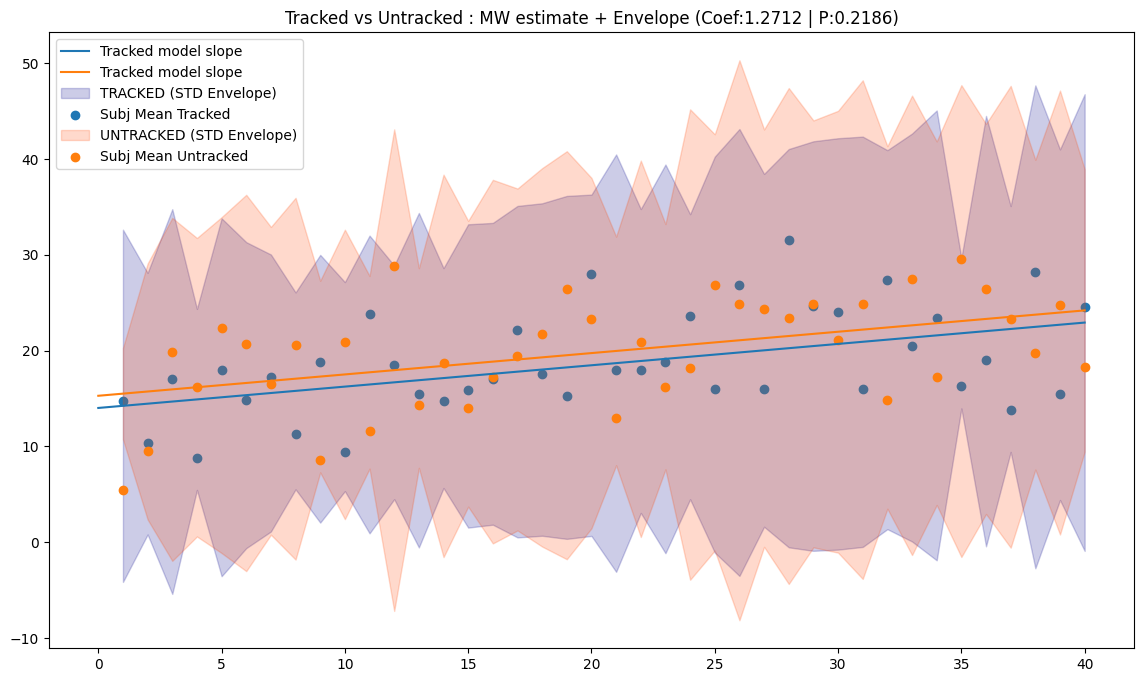

In [ ]:

### Get the parameters of a linear model: 
import matplotlib.pyplot as plt

# For Testing Main Effects 
coefs= []
zvals = []
pvals = []
conf1 = []
conf2 = []

# For Testing Trial Effect
coefsT= []
zvalsT = []
pvalsT = []
conf1T = []
conf2T = []


indx = []
eye = []
analysis = []
### Model Checks: 
import statsmodels.api  as sm

def linearModelChecks(m):
    # trial-level diagnostics
    resid   = m.resid                   # raw (conditional) residuals
    fitted  = m.fittedvalues            # conditional fitted values
    std_res = resid / np.sqrt(m.scale)  # ≈ studentised residuals
    fig,axs = plt.subplots(2,1,figsize=(14, 8))
    plt.suptitle("Checks for a Linear Model")

    # (1) Homoscedascisity
    axs[0].scatter(fitted, std_res, alpha=0.6, s=15)
    axs[0].axhline(0, linestyle='--')
    axs[0].set_xlabel("Fitted value")
    axs[0].set_ylabel("Studentised residual")
    axs[0].set_title("Residuals vs fitted")

    # (2) 
    sm.qqplot(std_res, line="45", fit=True, ax=axs[1])
    axs[1].set_title("Normal Q–Q")

    # (3) Colinearity:
    from patsy import dmatrices

    formula_fixed = "MW_Estimate ~ Tracking + trialNum"   # your fixed part
    y, X = dmatrices(formula_fixed, data=grand_df[['DS','trialNum','Tracking','MW_Estimate']], return_type="dataframe")
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    vif = pd.Series(
        [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
        index=X.columns
    )
    print(vif)

     # Drop the intercept from display (its VIF is usually not meaningful)
    vif_display = vif.drop('Intercept', errors='ignore')
    
    # Convert to multiline string
    vif_text = "\n".join([f"{k}: {v:.2f}" for k, v in vif_display.items()])
    vif_text = f"VIFs\n{vif_text}"

    axs[1].text(
        0.8, 0.5, vif_text,
        transform=axs[1].transAxes,
        verticalalignment='top',
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8)
    )
    plt.show()


def plotTrialTrack(m,name,grand_df,ax,titl):
  ### QUick Linear Model 
  quick_untracked_lm = lambda x: m.params[m.params.keys()[0]] + m.params[m.params.keys()[1]]+m.params[m.params.keys()[2]]*x 
  quick_tracked_lm = lambda x: m.params[m.params.keys()[0]] + m.params[m.params.keys()[2]]*x

  trialN = np.linspace(0,len(np.unique(grand_df['trialNum'])),len(np.unique(grand_df['trialNum']))+1);
  print(trialN)
  mw_est_utr = pd.Series(trialN).apply(quick_untracked_lm)
  mw_est_tr = pd.Series(trialN).apply(quick_tracked_lm)

  ax.set_title(titl)
  ax.plot(trialN,mw_est_tr,label="Tracked model slope")
  ax.plot(trialN,mw_est_utr,label="Tracked model slope")
  grTr = grand_df[[name,'trialNum','Tracking']].groupby(['Tracking','trialNum'])
  print(grTr.std().loc['TRACKED'][name])
  ax.fill_between(trialN, 
                  mw_est_tr - grTr.std().loc['TRACKED'][name], 
                    mw_est_tr+   grTr.std().loc['TRACKED'][name], 
                  color='darkblue', alpha=0.2, label='TRACKED (STD Envelope)')

  ax.scatter(grTr.mean().loc['TRACKED'].index,grTr.mean().loc['TRACKED'],label="Subj Mean Tracked")

  ax.fill_between(trialN, 
                  mw_est_utr - grTr.std().loc['UNTRACKED'][name], 
                    mw_est_utr+   grTr.std().loc['UNTRACKED'][name], 
                  color='orangered', alpha=0.2, label='UNTRACKED (STD Envelope)')
  ax.scatter(grTr.mean().loc['UNTRACKED'].index,grTr.mean().loc['UNTRACKED'],label="Subj Mean Untracked")
  ax.set_xlabel="Trial Number"
  ax.legend()
  

import statsmodels.formula.api as smf

m = smf.mixedlm("MW_Estimate ~ Tracking+trialNum ", data=grand_df[['DS','trialNum','Tracking','MW_Estimate']],
                groups="DS",          # random intercept
                #re_formula="~Tracking",         # adds random slope

               ).fit()
print(m.summary())   
coefs.append(m.params[m.params.keys()[1]])
zvals.append(m.tvalues[m.params.keys()[1]])
pvals.append(m.pvalues[m.params.keys()[1]])
conf1.append(m.conf_int().loc[m.params.keys()[1]][0])
conf2.append(m.conf_int().loc[m.params.keys()[1]][1])

coefsT.append(m.params[m.params.keys()[2]])
zvalsT.append(m.tvalues[m.params.keys()[2]])
pvalsT.append(m.pvalues[m.params.keys()[2]])
conf1T.append(m.conf_int().loc[m.params.keys()[2]][0])
conf2T.append(m.conf_int().loc[m.params.keys()[2]][1])

indx.append("MW Estimate")
eye.append('')
analysis.append('')

log_file.write("\n===# (1) Uncorrected Samples #=== \n\n")
log_file.write("(1.1) Uncorrected Samples (MW ~ Tracking +TrialNum +(1|Subjects)) \n")

log_file.write(f"      Tracking Effect        (Coef: {m.params[m.params.keys()[1]]:3.3f}| Z: {m.tvalues[m.params.keys()[1]]:3.3f}| P: {m.pvalues[m.params.keys()[1]]:3.3f} | Conf: {m.conf_int().loc[m.params.keys()[1]][0]:3.3f} {m.conf_int().loc[m.params.keys()[1]][1]:3.3f})\n")
log_file.write(f"      Trial Number Effect    (Coef: {m.params[m.params.keys()[2]]:3.3f}| Z: {m.tvalues[m.params.keys()[2]]:3.3f}| P: {m.pvalues[m.params.keys()[2]]:3.3f} | Conf: {m.conf_int().loc[m.params.keys()[2]][0]:3.3f} {m.conf_int().loc[m.params.keys()[2]][1]:3.3f})\n")


fig, ax = plt.subplots(figsize=(14, 8))
plotTrialTrack(m,'MW_Estimate',grand_df,ax,titl=f"Tracked vs Untracked : MW estimate + Envelope (Coef:{ m.params[m.params.keys()[1]]:1.4f} | P:{ m.pvalues[m.params.keys()[1]]:1.4f})" )
plt.savefig(os.path.join(statPath,f"MWvsUntracked_Uncorr_{est}.png"))



Intercept                5.128910
Tracking[T.UNTRACKED]    1.000281
trialNum                 1.000281
dtype: float64


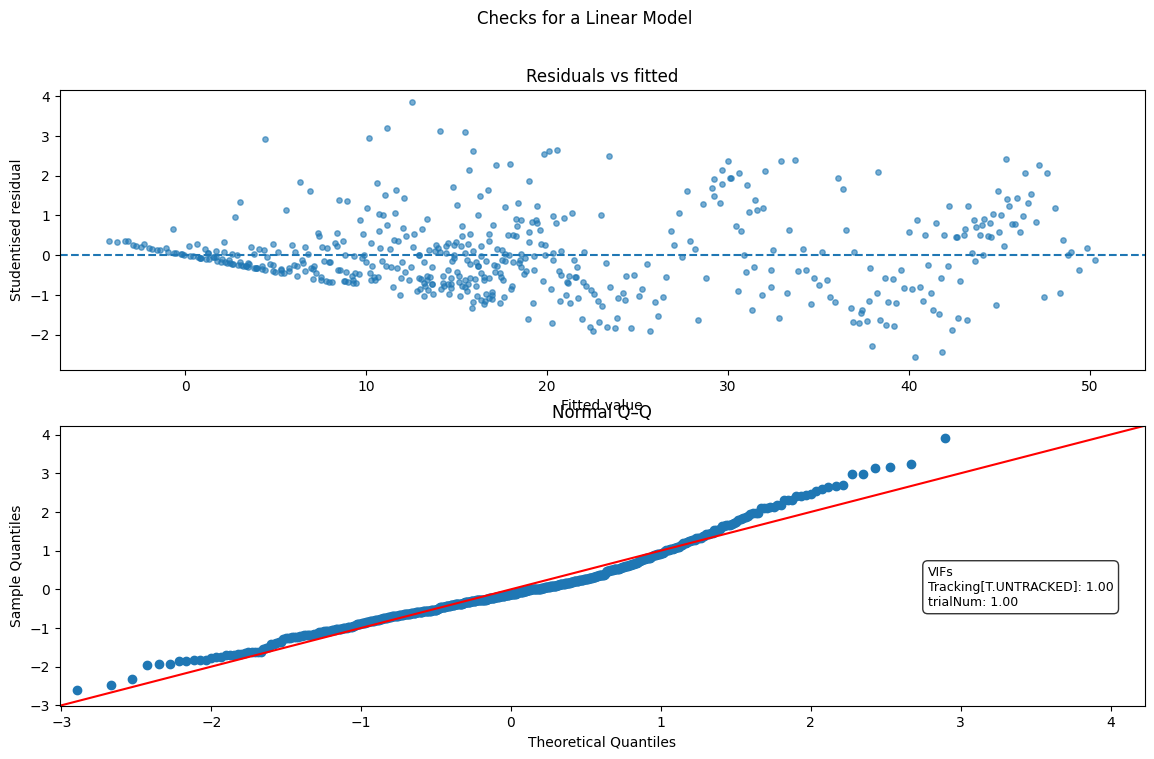

In [73]:
linearModelChecks(m)


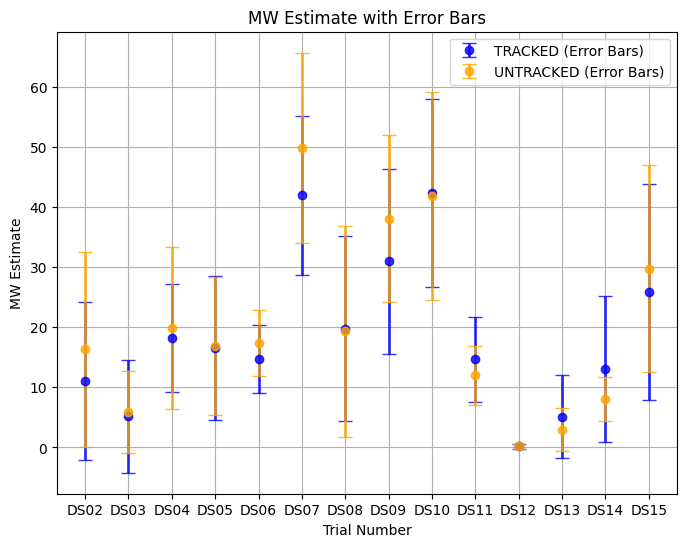

In [ ]:
mew = grand_df[grand_df['Tracking'] == 'TRACKED'][['DS','MW_Estimate']].groupby(['DS'])
umew = grand_df[grand_df['Tracking'] == 'UNTRACKED'][['DS','MW_Estimate']].groupby(['DS'])


plt.figure(figsize=(8, 6))

# Plot for TRACKED group
plt.errorbar(mew.mean().index, 
             mew.mean()['MW_Estimate'].values, 
             yerr=mew.std()['MW_Estimate'].values, 
             fmt='o', color='blue', label='TRACKED (Error Bars)', alpha=0.8, 
             capsize=5, elinewidth=2)  # Adjust capsize and line width

# Plot for UNTRACKED group
plt.errorbar(umew.mean().index, 
             umew.mean()['MW_Estimate'].values, 
             yerr=umew.std()['MW_Estimate'].values, 
             fmt='o', color='orange', label='UNTRACKED (Error Bars)', alpha=0.8, 
             capsize=5, elinewidth=2)  # Adjust capsize and line width

# Add labels, legend, and title
plt.xlabel('Trial Number')
plt.ylabel('MW Estimate')
plt.title('MW Estimate with Error Bars')
plt.legend()
plt.grid(True)

# Show the plot
plt.savefig(os.path.join(statPath,f"MWacrossSubj_{est}.png"))


#### (1.2) Test Whether Pupil Diameter Differs between Tracked and Untracked Entity: 

We controll immediatley for SUBJECTS

so Making Basic Models:

        Pupil ~ Tracking +trialNum + (1|Subjects)




======== Test for Pupil Diameter Mean // Left_Eye =======

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Pupil     
No. Observations:      526          Method:                  REML      
No. Groups:            14           Scale:                   88415.9854
Min. group size:       27           Log-Likelihood:          -3751.1913
Max. group size:       40           Converged:               Yes       
Mean group size:       37.6                                            
-----------------------------------------------------------------------
                        Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------
Intercept              -356.357   64.029 -5.566 0.000 -481.852 -230.863
Tracking[T.UNTRACKED]    36.034   25.967  1.388 0.165  -14.861   86.929
trialNum                  2.497    1.128  2.213 0.027    0.286    4.708
DS Var              

c:\Users\barak\Documents\GitHub\startegicMW_lite\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\barak\Documents\GitHub\startegicMW_lite\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


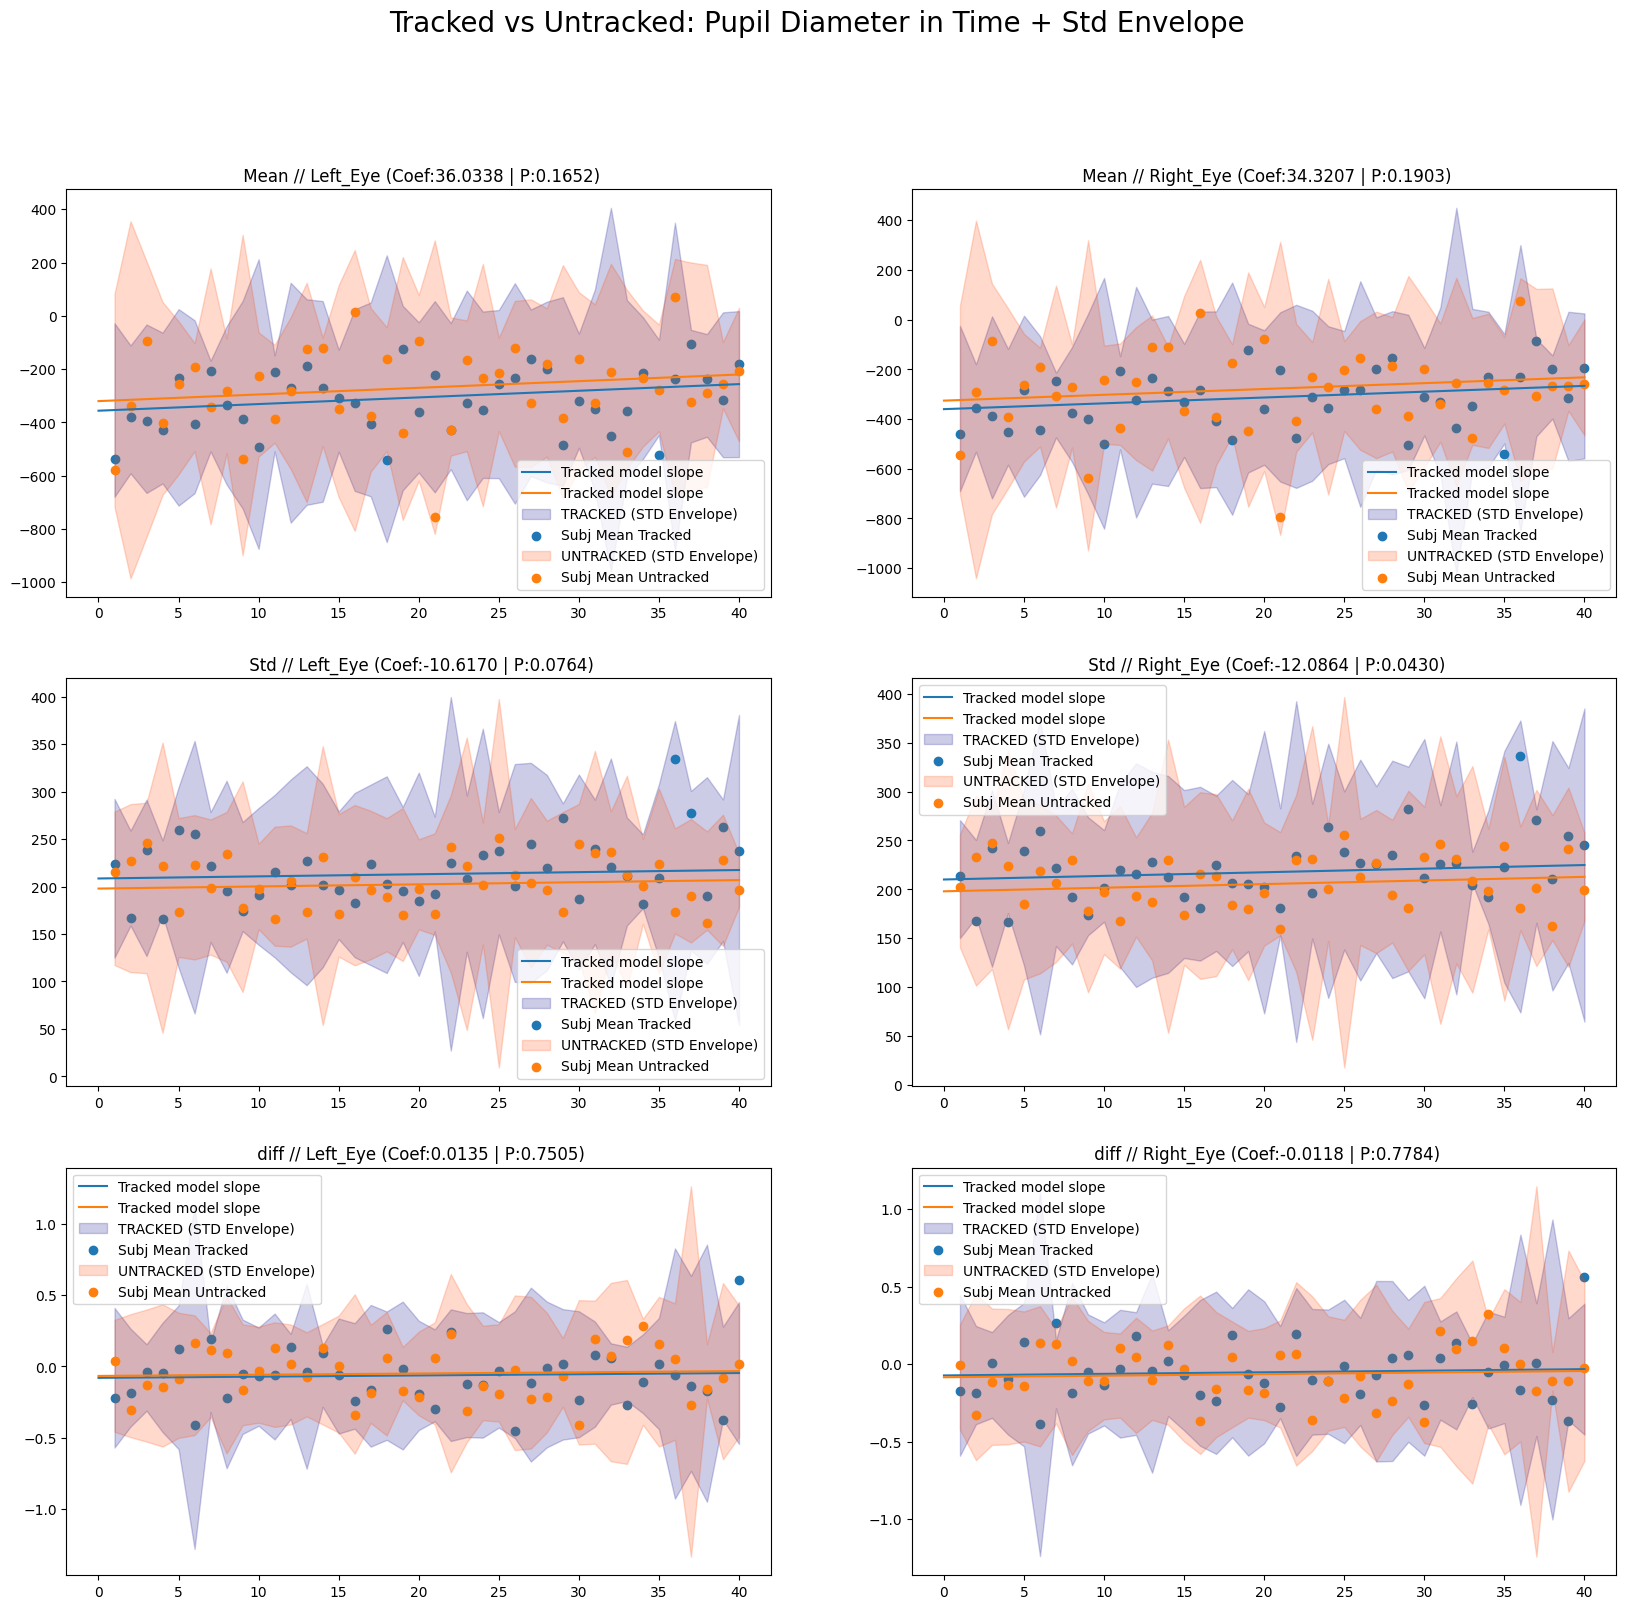

In [ ]:
import statsmodels.formula.api as smf
models = []

fig, axes = plt.subplots(3,2,figsize=(20,18))
fig.suptitle("Tracked vs Untracked: Pupil Diameter in Time + Std Envelope",fontsize=20)
axes = axes.flatten()  # Flatten to easily iterate over axes
log_file.write("\n(1.2) Pupil Diameter vs Tracking (Pupil ~ Tracking +TrialNum +(1|Subjects)) \n")

for i, ind in enumerate(grand_df['Pupil_Diameter'].columns):
    print("\n\n=============================================================")
    print(f"======== Test for Pupil Diameter {ind[0]} // {ind[1]} =======")
    print("=============================================================\n")

    # Create the DataFrame and transpose it
    currentDf = pd.DataFrame([grand_df['Pupil_Diameter'][ind[0]][ind[1]], grand_df['DS'], grand_df['trialNum'], grand_df['Tracking']]).T
    currentDf.columns = ['Pupil', 'DS', 'trialNum', 'Tracking']
    currentDf['trialNum'] = pd.to_numeric(currentDf['trialNum'], errors='coerce')  # Ensure numeric
    
    
    # Clean the data
    currentDf = currentDf.dropna(subset=['Pupil', 'Tracking', 'trialNum'])  # Drop rows with NaN
    currentDf['Pupil'] = pd.to_numeric(currentDf['Pupil'], errors='coerce')  # Ensure numeric

    # Fit the mixed effects model
    m = smf.mixedlm("Pupil ~ Tracking + trialNum", data=currentDf,
                    groups="DS",  # Random intercept
                    ).fit()
    
    models.append(m)
    print(m.summary())  # ≈ summary(lm(...)) in R

    
    log_file.write(f"    {ind[0]} // {ind[1]}  \n")

    log_file.write(f"      Tracking Effect        (Coef: {m.params[m.params.keys()[1]]:3.3f}| Z: {m.tvalues[m.params.keys()[1]]:3.3f}| P: {m.pvalues[m.params.keys()[1]]:3.3f} | Conf: {m.conf_int().loc[m.params.keys()[1]][0]:3.3f} {m.conf_int().loc[m.params.keys()[1]][1]:3.3f})\n")
    log_file.write(f"      Trial Number Effect    (Coef: {m.params[m.params.keys()[2]]:3.3f}| Z: {m.tvalues[m.params.keys()[2]]:3.3f}| P: {m.pvalues[m.params.keys()[2]]:3.3f} | Conf: {m.conf_int().loc[m.params.keys()[2]][0]:3.3f} {m.conf_int().loc[m.params.keys()[2]][1]:3.3f})\n")
    
    coefs.append(m.params[m.params.keys()[1]])
    zvals.append(m.tvalues[m.params.keys()[1]])
    pvals.append(m.pvalues[m.params.keys()[1]])
    conf1.append(m.conf_int().loc[m.params.keys()[1]][0])
    conf2.append(m.conf_int().loc[m.params.keys()[1]][1])

    coefsT.append(m.params[m.params.keys()[2]])
    zvalsT.append(m.tvalues[m.params.keys()[2]])
    pvalsT.append(m.pvalues[m.params.keys()[2]])
    conf1T.append(m.conf_int().loc[m.params.keys()[2]][0])
    conf2T.append(m.conf_int().loc[m.params.keys()[2]][1])
    indx.append("Pupil Diam")
    eye.append(ind[0])
    analysis.append(ind[1])

    plotTrialTrack(m,"Pupil",currentDf,axes[i],titl=f" {ind[0]} // {ind[1]} (Coef:{ m.params[m.params.keys()[1]]:1.4f} | P:{ m.pvalues[m.params.keys()[1]]:1.4f})")
df = pd.DataFrame([],columns = ["Coefs",'Zval','P','Conf1','Conf2'])

plt.savefig(os.path.join(statPath,f"PupilvsTracking_Unc_{est}.png"))

In [31]:
df

,Coefs,Zval,P,Conf1,Conf2



#### (1.3) Test Whether Pupil Diameter and MW Estimates ARE Tracking Each other 

We controll immediatley for SUBJECTS

so Making Basic Models:

        Pupil ~ MW_Estimate +trialNum + (1|Subjects)




======== Test for Pupil Diameter Mean // Left_Eye =======

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Pupil     
No. Observations:      526          Method:                  REML      
No. Groups:            14           Scale:                   88482.3691
Min. group size:       27           Log-Likelihood:          -3749.7569
Max. group size:       40           Converged:               Yes       
Mean group size:       37.6                                            
-----------------------------------------------------------------------
                        Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------
Intercept              -370.581   65.285 -5.676 0.000 -498.538 -242.625
Tracking[T.UNTRACKED]    34.759   26.013  1.336 0.181  -16.225   85.743
MW_Estimate               1.013    1.080  0.938 0.348   -1.104    3.130
trialNum            

c:\Users\barak\Documents\GitHub\startegicMW_lite\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\barak\Documents\GitHub\startegicMW_lite\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    Pupil    
No. Observations:    526        Method:                REML     
No. Groups:          14         Scale:                 0.2373   
Min. group size:     27         Log-Likelihood:        -382.7203
Max. group size:     40         Converged:             Yes      
Mean group size:     37.6                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             -0.067    0.051 -1.314 0.189 -0.168  0.033
Tracking[T.UNTRACKED]  0.015    0.043  0.343 0.731 -0.069  0.098
MW_Estimate           -0.001    0.001 -0.753 0.452 -0.003  0.001
trialNum               0.001    0.002  0.562 0.574 -0.003  0.005
DS Var                 0.000    0.005                           



======== Test for Pupil Diameter dif

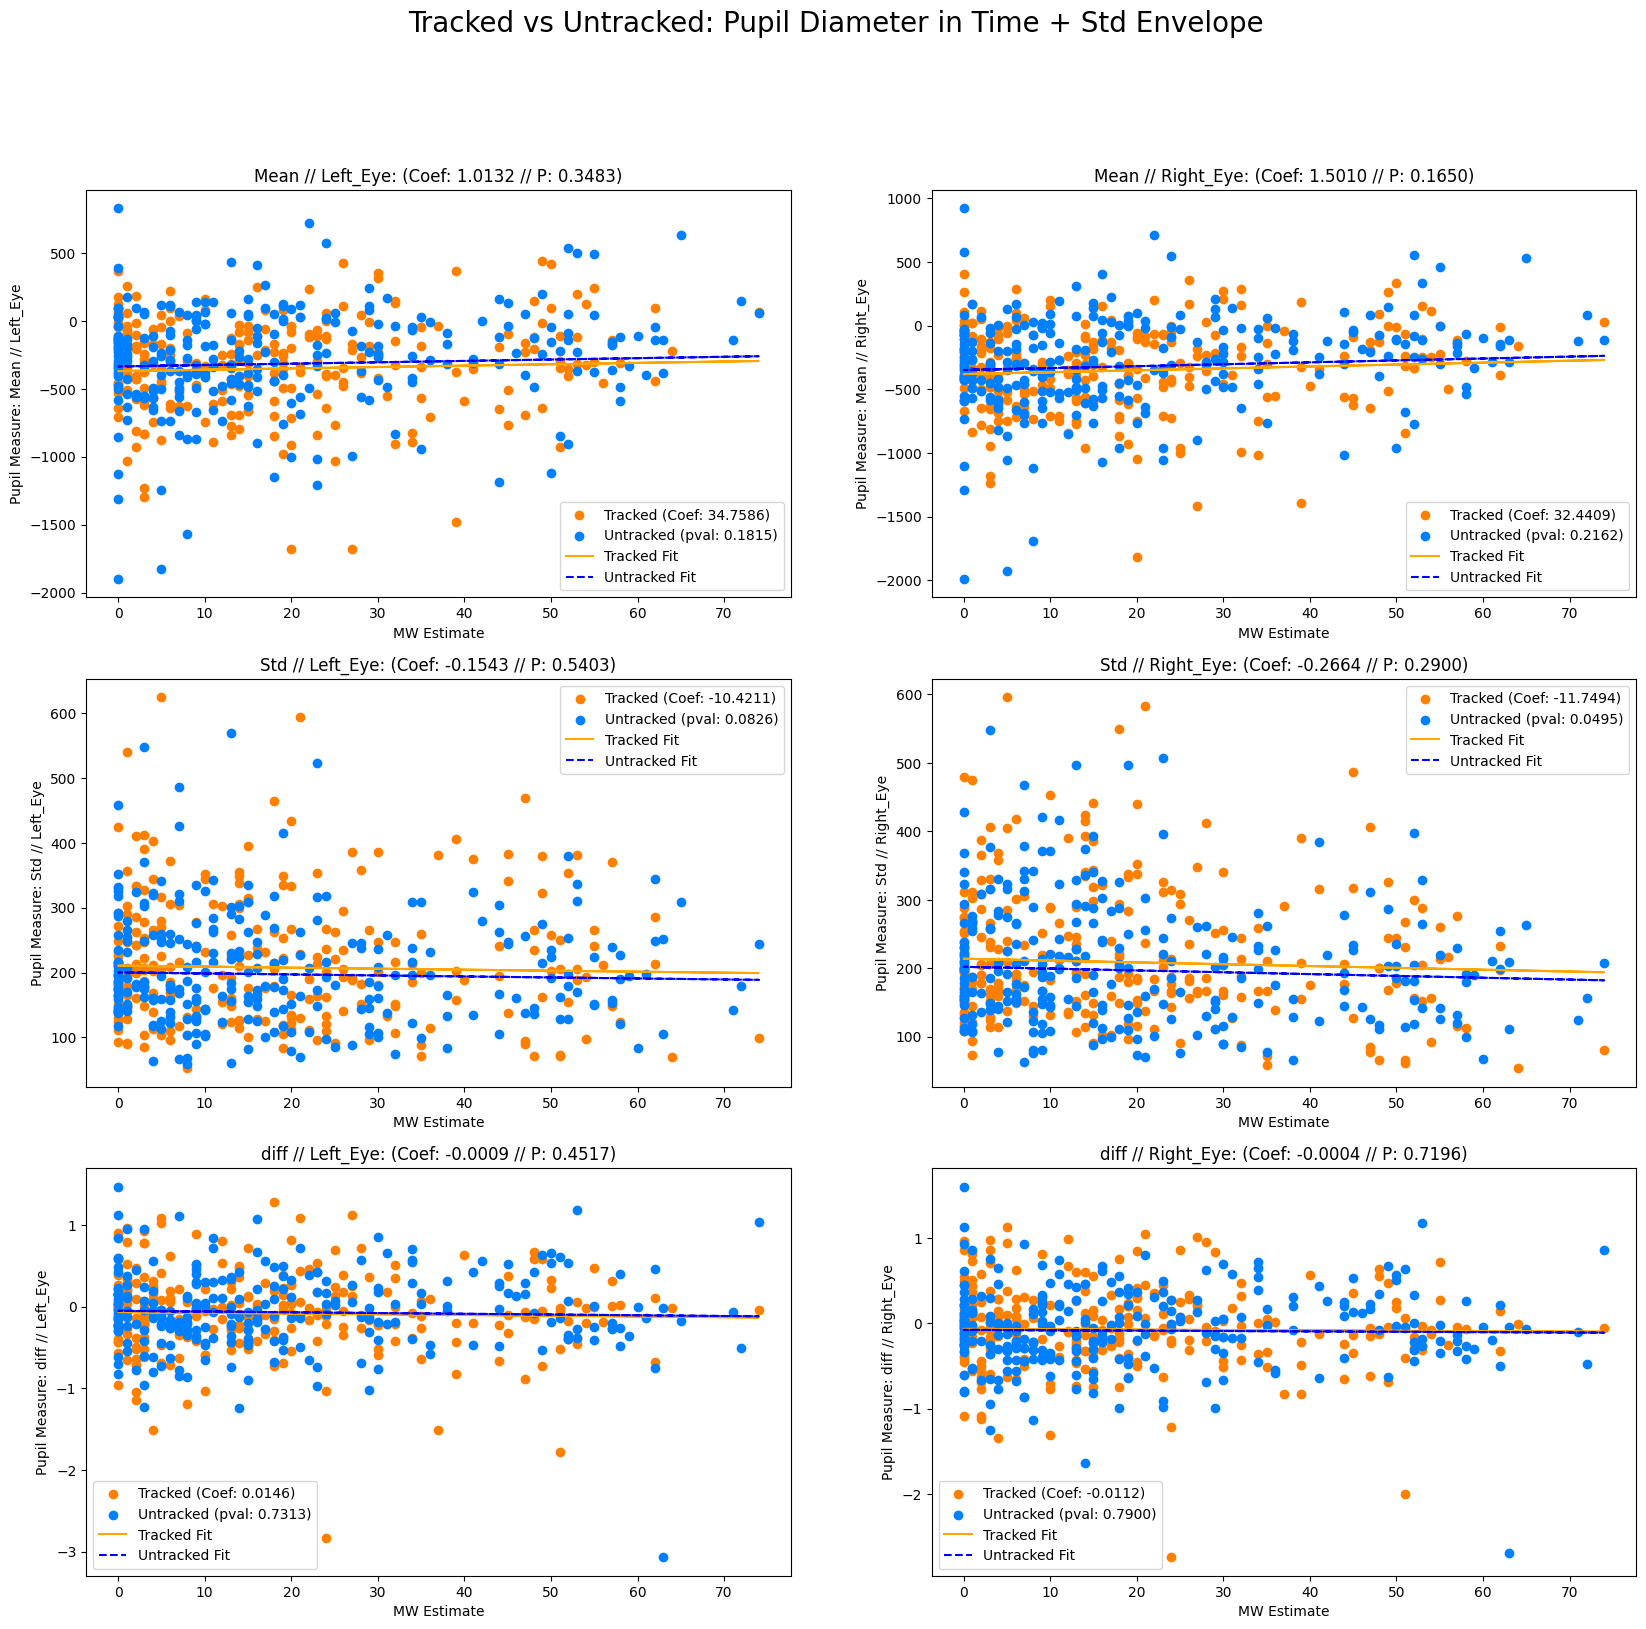

In [ ]:
import statsmodels.formula.api as smf
models = []

import matplotlib.pyplot as plt

def plot_pupil_vs_mw(m, currentDf, ind, ax=None):
    """
    Plot Pupil vs MW_Estimate with linear fits for TRACKED and UNTRACKED groups.
    
    Parameters:
    - m: Fitted mixed effects model.
    - currentDf: DataFrame containing the data.
    - ind: Tuple indicating the current column (e.g., ('Pupil', 'Diameter')).
    - ax: Matplotlib Axes object. If None, a new figure will be created.
    """
    # Create a new figure and axis if no Axes object is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define linear functions for TRACKED and UNTRACKED
    linfunTr = lambda x: m.params[m.params.keys()[0]] + m.params[m.params.keys()[2]] * x
    linfunUnTr = lambda x: m.params[m.params.keys()[0]] + m.params[m.params.keys()[2]] * x + m.params[m.params.keys()[1]]

    # Scatter plot for TRACKED and UNTRACKED
    ax.scatter(currentDf[currentDf['Tracking'] == 'TRACKED']['MW_Estimate'],
               currentDf[currentDf['Tracking'] == 'TRACKED']['Pupil'],
               color=[1, 0.5, 0], label=f"Tracked (Coef: {m.params[m.params.keys()[1]]:1.4f})")
    ax.scatter(currentDf[currentDf['Tracking'] == 'UNTRACKED']['MW_Estimate'],
               currentDf[currentDf['Tracking'] == 'UNTRACKED']['Pupil'],
               color=[0, 0.5, 1], label=f"Untracked (pval: {m.pvalues[m.params.keys()[1]]:1.4f})")

    # Plot linear fits
    ax.plot(currentDf['MW_Estimate'], linfunTr(currentDf['MW_Estimate']), 'orange', label="Tracked Fit")
    ax.plot(currentDf['MW_Estimate'], linfunUnTr(currentDf['MW_Estimate']), 'b--', label="Untracked Fit")

    # Add labels, title, and legend
    ax.set_xlabel('MW Estimate')
    ax.set_ylabel(f"Pupil Measure: {ind[0]} // {ind[1]}")
    ax.set_title(f"{ind[0]} // {ind[1]}: (Coef: {m.params[m.params.keys()[2]]:1.4f} // P: {m.pvalues[m.params.keys()[2]]:1.4f})")
    ax.legend()

    # Add a suptitle if it's a standalone plot
    if ax is None:
        plt.suptitle(f"MW Estimate vs Pupil Measure")
        plt.show()


fig, axes = plt.subplots(3, 2, figsize=(20, 18))  # Adjust rows/columns as needed
fig.suptitle("Tracked vs Untracked: Pupil Diameter in Time + Std Envelope", fontsize=20)
axes = axes.flatten()  # Flatten to easily iterate over axes

log_file.write("\n(1.3) Pupil Diameter vs MW (Pupil ~ MW +Tracking +(1|Subjects)) \n")

for i, ind in enumerate(grand_df['Pupil_Diameter'].columns):
    print("\n\n=============================================================")
    print(f"======== Test for Pupil Diameter {ind[0]} // {ind[1]} =======")
    print("=============================================================\n")

    # Create the DataFrame and transpose it
    currentDf = pd.DataFrame([grand_df['Pupil_Diameter'][ind[0]][ind[1]], grand_df['MW_Estimate'], grand_df['DS'], grand_df['trialNum'], grand_df['Tracking']]).T
    currentDf.columns = ['Pupil','MW_Estimate', 'DS', 'trialNum', 'Tracking']

    currentDf['MW_Estimate'] = pd.to_numeric(currentDf['MW_Estimate'], errors='coerce')   # <─ add this
    # Clean the data
    currentDf = currentDf.dropna(subset=['Pupil','MW_Estimate', 'Tracking', 'trialNum'])  # Drop rows with NaN
    currentDf['Pupil'] = pd.to_numeric(currentDf['Pupil'], errors='coerce')  # Ensure numeric
    currentDf['trialNum'] = pd.to_numeric(currentDf['trialNum'], errors='coerce')  # Ensure numeric

    # Fit the mixed effects model
    m = smf.mixedlm("Pupil ~ MW_Estimate +Tracking  +trialNum", data=currentDf,
                    groups="DS",  # Random intercept
                    ).fit()
    
    models.append(m)
     
    log_file.write(f"    {ind[0]} // {ind[1]}  \n")

    log_file.write(f"      Tracking Effect        (Coef: {m.params[m.params.keys()[1]]:3.3f}| Z: {m.tvalues[m.params.keys()[1]]:3.3f}| P: {m.pvalues[m.params.keys()[1]]:3.3f} | Conf: {m.conf_int().loc[m.params.keys()[1]][0]:3.3f} {m.conf_int().loc[m.params.keys()[1]][1]:3.3f})\n")
    log_file.write(f"      MW Estimate Effect     (Coef: {m.params[m.params.keys()[2]]:3.3f}| Z: {m.tvalues[m.params.keys()[2]]:3.3f}| P: {m.pvalues[m.params.keys()[2]]:3.3f} | Conf: {m.conf_int().loc[m.params.keys()[2]][0]:3.3f} {m.conf_int().loc[m.params.keys()[2]][1]:3.3f})\n")

    coefs.append(m.params[m.params.keys()[2]])
    zvals.append(m.tvalues[m.params.keys()[2]])
    pvals.append(m.pvalues[m.params.keys()[2]])
    conf1.append(m.conf_int().loc[m.params.keys()[2]][0])
    conf2.append(m.conf_int().loc[m.params.keys()[2]][1])

    coefsT.append(m.params[m.params.keys()[3]])
    zvalsT.append(m.tvalues[m.params.keys()[3]])
    pvalsT.append(m.pvalues[m.params.keys()[3]])
    conf1T.append(m.conf_int().loc[m.params.keys()[3]][0])
    conf2T.append(m.conf_int().loc[m.params.keys()[3]][1])

    indx.append("Pupil x MW")
    eye.append(ind[0])
    analysis.append(ind[1])

    print(m.summary())  # ≈ summary(lm(...)) in R
    plot_pupil_vs_mw(m, currentDf, ind, ax=axes[i])
plt.savefig(os.path.join(statPath,f"PupilvsMW_Untr_{est}.png"))

### (1.4) Left-Right Gaze Difference




              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  GazeDifference
No. Observations:    526      Method:              REML          
No. Groups:          14       Scale:               458.7156      
Min. group size:     27       Log-Likelihood:      -2373.5176    
Max. group size:     40       Converged:           Yes           
Mean group size:     37.6                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              50.678    4.117 12.310 0.000 42.609 58.746
Tracking[T.UNTRACKED]   0.286    1.870  0.153 0.879 -3.380  3.951
trialNum               -0.231    0.081 -2.837 0.005 -0.390 -0.071
DS Var                174.405    3.452                           



C:\Users\barak\AppData\Local\Temp\ipykernel_84584\1234778342.py:89: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mw_est_tr - grTr.std().loc['TRACKED'][name],


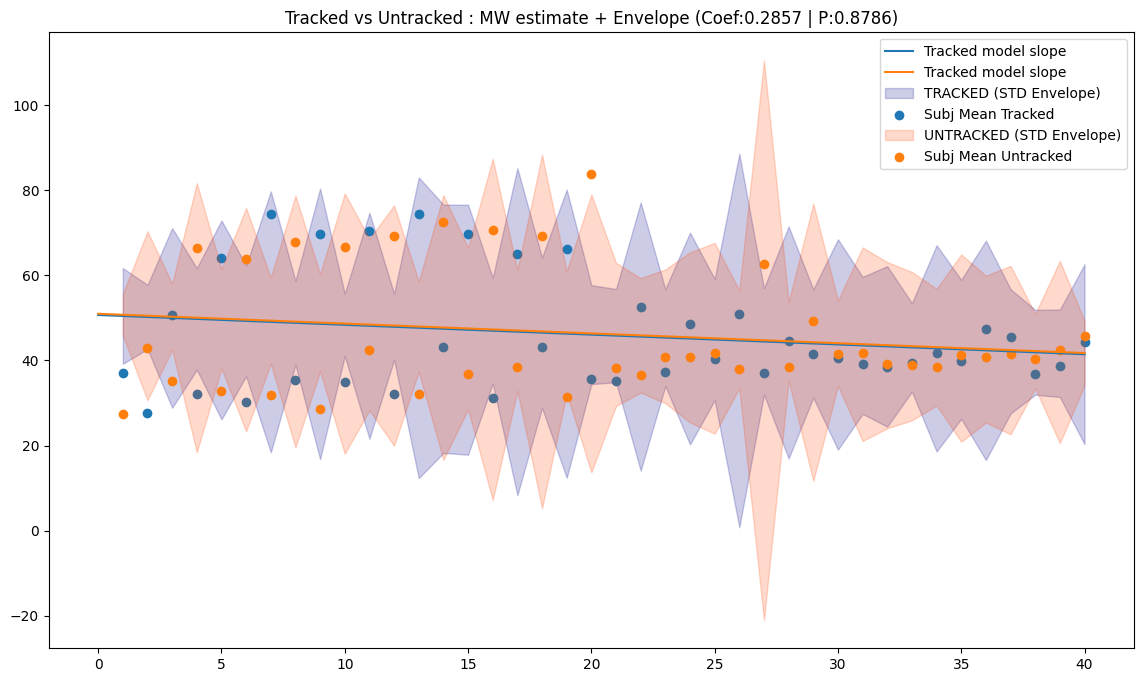

In [ ]:
# Combine single-level and multi-level columns
subset = pd.concat([
    grand_df[('MW_Estimate', '', '')].rename('MW_Estimate'),

    grand_df[('Tracking', '', '')].rename('Tracking'),
    grand_df[('DS', '', '')].rename('DS'),
    grand_df[('trialNum', '', '')].rename('trialNum'),
    grand_df[('Checks', '', 'gazeDiff')].rename('gazeDiff')
], axis=1)



import statsmodels.formula.api as smf

m = smf.mixedlm("GazeDifference ~ Tracking+trialNum ", data=grand_df[['MW_Estimate','DS','Tracking','trialNum','GazeDifference']],
                groups="DS",          # random intercept
                #re_formula="~Tracking",         # adds random slope

               ).fit()
print(m.summary())   
coefs.append(m.params[m.params.keys()[1]])
zvals.append(m.tvalues[m.params.keys()[1]])
pvals.append(m.pvalues[m.params.keys()[1]])
conf1.append(m.conf_int().loc[m.params.keys()[1]][0])
conf2.append(m.conf_int().loc[m.params.keys()[1]][1])

coefsT.append(m.params[m.params.keys()[2]])
zvalsT.append(m.tvalues[m.params.keys()[2]])
pvalsT.append(m.pvalues[m.params.keys()[2]])
conf1T.append(m.conf_int().loc[m.params.keys()[2]][0])
conf2T.append(m.conf_int().loc[m.params.keys()[2]][1])

indx.append("Gaze Difference ")
eye.append('')
analysis.append('')

log_file.write("\n===# (1) Uncorrected Samples #=== \n\n")
log_file.write("(1.1) Uncorrected Samples (MW ~ Tracking +TrialNum +(1|Subjects)) \n")

log_file.write(f"      Tracking Effect        (Coef: {m.params[m.params.keys()[1]]:3.3f}| Z: {m.tvalues[m.params.keys()[1]]:3.3f}| P: {m.pvalues[m.params.keys()[1]]:3.3f} | Conf: {m.conf_int().loc[m.params.keys()[1]][0]:3.3f} {m.conf_int().loc[m.params.keys()[1]][1]:3.3f})\n")
log_file.write(f"      Trial Number Effect    (Coef: {m.params[m.params.keys()[2]]:3.3f}| Z: {m.tvalues[m.params.keys()[2]]:3.3f}| P: {m.pvalues[m.params.keys()[2]]:3.3f} | Conf: {m.conf_int().loc[m.params.keys()[2]][0]:3.3f} {m.conf_int().loc[m.params.keys()[2]][1]:3.3f})\n")


fig, ax = plt.subplots(figsize=(14, 8))
plotTrialTrack(m,'GazeDifference',grand_df,ax,titl=f"Tracked vs Untracked : MW estimate + Envelope (Coef:{ m.params[m.params.keys()[1]]:1.4f} | P:{ m.pvalues[m.params.keys()[1]]:1.4f})" )
plt.savefig(os.path.join(statPath,f"GazeDiff_TrVsUntr_{est}.png"))



C:\Users\barak\AppData\Local\Temp\ipykernel_84584\3798952085.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  plt.errorbar(mew.mean().index,
C:\Users\barak\AppData\Local\Temp\ipykernel_84584\3798952085.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  plt.errorbar(umew.mean().index,


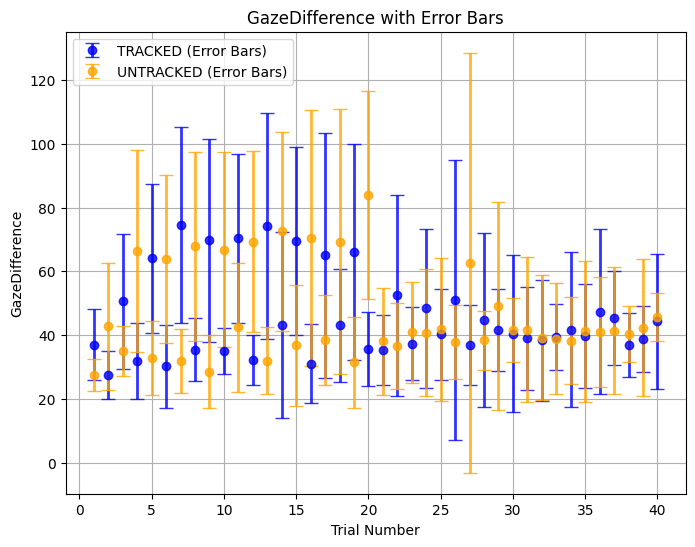

In [ ]:
mew = grand_df[grand_df['Tracking'] == 'TRACKED'][['trialNum','GazeDifference']].groupby(['trialNum'])
umew = grand_df[grand_df['Tracking'] == 'UNTRACKED'][['trialNum','GazeDifference']].groupby(['trialNum'])


plt.figure(figsize=(8, 6))

# Plot for TRACKED group
plt.errorbar(mew.mean().index, 
             mew.mean()['GazeDifference'].values, 
             yerr=mew.std()['GazeDifference'].values, 
             fmt='o', color='blue', label='TRACKED (Error Bars)', alpha=0.8, 
             capsize=5, elinewidth=2)  # Adjust capsize and line width

# Plot for UNTRACKED group
plt.errorbar(umew.mean().index, 
             umew.mean()['GazeDifference'].values, 
             yerr=umew.std()['GazeDifference'].values, 
             fmt='o', color='orange', label='UNTRACKED (Error Bars)', alpha=0.8, 
             capsize=5, elinewidth=2)  # Adjust capsize and line width

# Add labels, legend, and title
plt.xlabel('Trial Number')
plt.ylabel('GazeDifference')
plt.title('GazeDifference with Error Bars')
plt.legend()
plt.grid(True)

# Show the plot
plt.savefig(os.path.join(statPath,f"GazeDiffacrossSubj__{est}.png"))

In [ ]:

# Create a MultiIndex DataFrame and Save All Our Data 
index = pd.MultiIndex.from_arrays([ indx, eye, analysis], names=['Analysis Name', 'Eye', 'Mode'])
stats_df = pd.DataFrame({('Main','Coefficient'): coefs,  ('Main','Z-score'): zvals ,('Main','p-value'): pvals,('Main','conf1'):conf1,('Main','conf2'):conf2,
                         ('Trial','Coefficient'): coefsT,  ('Trial','Z-score'): zvalsT ,('Trial','p-value'): pvalsT,('Trial','conf1'):conf1T,('Trial','conf2'):conf2T}, index=index)

stats_df.to_excel(os.path.join(statPath,f"statistics_unc_{est}.xlsx"))


PermissionError: [Errno 13] Permission denied: 'c:\\Users\\barak\\Documents\\GitHub\\startegicMW_lite\\Experiment\\analysis\\TEST_res100_dgv5_bll500_blb75_smw10_smL2000_swG50_trO10000_trB5000\\summary\\statistics_unc.xlsx'

## (2) CORRECTED: Test Is Tracked Entity Different from Untracked Entity?

Since there are some trials and subjects that are clearly Unreliable, we can exclude them based on preordained criteria:

(WARNING it may be relevant only for Pupil Diameter dependent measures )

- Those that No-Pupi Events (Blinks, Outside of the screen) have not been more than 10%
- Those that General No screen + Clustering have not been 75%
- Those in which Pupil Period is not contaminated by Measurments and the rate of artefacts is less than 0.05

#### (1.1) Test Whether Pupil Diameter Differs between Tracked and Untracked Entity: 

We controll immediatley for SUBJECTS

so Making Basic Models:

        MW_estimate ~ Tracking +trialNum + (1|Subjects)


Additionally we plot the Envelope of STD from subjects as well as provide the Mean differs across subjects of MW Both in TIme as in Absolute:

Important here to check:
+ Whether there is a difference between Tracked and Untracked Entity
+ Whether there is an Effect of Trial Number (As MW Rate should increase in time)

In [ ]:


def qualityChecks(grand_df,column):
    partiaclCheck1 = grand_df[grand_df['Checks']['']['goodRatio'+column] > 0.75]
    partiaclCheck2 = partiaclCheck1[partiaclCheck1['Checks']['']['goodPupRatio'+column] > 0.95]

    trmw1 = partiaclCheck1[partiaclCheck1['Tracking']=="TRACKED"].groupby(['Tracking','DS'])
    untrmw1  = partiaclCheck1[partiaclCheck1['Tracking']=="UNTRACKED"].groupby(['Tracking','DS'])

    trmw2 = partiaclCheck2[partiaclCheck2['Tracking']=="TRACKED"].groupby(['Tracking','DS'])
    untrmw2  = partiaclCheck2[partiaclCheck2['Tracking']=="UNTRACKED"].groupby(['Tracking','DS'])


    return partiaclCheck1,partiaclCheck2,trmw1,untrmw1,trmw2,untrmw2



partiaclCheck0 = grand_df[grand_df['Checks']['']['gazeRate'] <0.1]
partiaclCheck1L,partiaclCheck2L,trmw1L,untrmw1L,trmw2L,untrmw2L =  qualityChecks(partiaclCheck0,'Left')
partiaclCheck1R,partiaclCheck2R,trmw1R,untrmw1R,trmw2R,untrmw2R =  qualityChecks(partiaclCheck0,'Right')

mw = grand_df[grand_df['Tracking'] == 'TRACKED'].groupby(['Tracking','DS'])
umw = grand_df[grand_df['Tracking'] == 'UNTRACKED'].groupby(['Tracking','DS'])

trmw = partiaclCheck0[partiaclCheck0['Tracking']=="TRACKED"].groupby(['Tracking','DS'])
untrmw  = partiaclCheck0[partiaclCheck0['Tracking']=="UNTRACKED"].groupby(['Tracking','DS'])


log_file.write("\n===# CHECKS #=== \n\n")
log_file.write(f"   Gaze Rate Rej Threshold:      {0.1*100}%\n")
log_file.write(f"      N. After Removal:           (Tr: {int(trmw.count().sum().loc['MW_Estimate'].iloc[0])}/{int(mw.count().sum().loc['MW_Estimate'].iloc[0])} || Untr: {int(untrmw.count().sum().loc['MW_Estimate'].iloc[0])}/{int(umw.count().sum().loc['MW_Estimate'].iloc[0])} )\n")
log_file.write(f"   Left NaN Rej Threshold:       {0.1*100}%\n")
log_file.write(f"      N. After Removal:           (Tr: {int(trmw1L.count().sum().loc['MW_Estimate'].iloc[0])}/{int(mw.count().sum().loc['MW_Estimate'].iloc[0])} || Untr: {int(untrmw1L.count().sum().loc['MW_Estimate'].iloc[0])}/{int(umw.count().sum().loc['MW_Estimate'].iloc[0])} )\n")
log_file.write(f"   Right NaN Rej Threshold:      {0.1*100}%\n")
log_file.write(f"      N. After Removal:           (Tr: {int(trmw1R.count().sum().loc['MW_Estimate'].iloc[0])}/{int(mw.count().sum().loc['MW_Estimate'].iloc[0])} || Untr: {int(untrmw1R.count().sum().loc['MW_Estimate'].iloc[0])}/{int(umw.count().sum().loc['MW_Estimate'].iloc[0])} )\n")
log_file.write(f"   Left Pup NaN Rej Threshold:   {0.1*100}%\n")
log_file.write(f"      N. After Removal:           (Tr: {int(trmw2L.count().sum().loc['MW_Estimate'].iloc[0])}/{int(mw.count().sum().loc['MW_Estimate'].iloc[0])} || Untr: {int(untrmw2L.count().sum().loc['MW_Estimate'].iloc[0])}/{int(umw.count().sum().loc['MW_Estimate'].iloc[0])} )\n")
log_file.write(f"   Right Pup NaN Rej Threshold:  {0.1*100}%\n\n")
log_file.write(f"      N. After Removal:           (Tr: {int(trmw2R.count().sum().loc['MW_Estimate'].iloc[0])}/{int(mw.count().sum().loc['MW_Estimate'].iloc[0])} || Untr: {int(untrmw2R.count().sum().loc['MW_Estimate'].iloc[0])}/{int(umw.count().sum().loc['MW_Estimate'].iloc[0])} )\n")

print(f"   Gaze Rate Rej Threshold:      {0.1*100}%")
print(f"      N. After Removal:           (Tr: {int(trmw.count().sum().loc['MW_Estimate'].iloc[0])}/{int(mw.count().sum().loc['MW_Estimate'].iloc[0])} || Untr: {int(untrmw.count().sum().loc['MW_Estimate'].iloc[0])}/{int(umw.count().sum().loc['MW_Estimate'].iloc[0])} )")
print(f"   NaN Rej Threshold:            {0.751*100}%")
print(f"      N. After Removal:           (Tr: {int(trmw1L.count().sum().loc['MW_Estimate'].iloc[0])}/{int(mw.count().sum().loc['MW_Estimate'].iloc[0])} || Untr: {int(untrmw1L.count().sum().loc['MW_Estimate'].iloc[0])}/{int(umw.count().sum().loc['MW_Estimate'].iloc[0])} )")
print(f"      N. After Removal:           (Tr: {int(trmw1R.count().sum().loc['MW_Estimate'].iloc[0])}/{int(mw.count().sum().loc['MW_Estimate'].iloc[0])} || Untr: {int(untrmw1R.count().sum().loc['MW_Estimate'].iloc[0])}/{int(umw.count().sum().loc['MW_Estimate'].iloc[0])} )")
print(f"   Pup NaN Rej Threshold:        {0.95*100}%")
print(f"      N. After Removal:           (Tr: {int(trmw2L.count().sum().loc['MW_Estimate'].iloc[0])}/{int(mw.count().sum().loc['MW_Estimate'].iloc[0])} || Untr: {int(untrmw2L.count().sum().loc['MW_Estimate'].iloc[0])}/{int(umw.count().sum().loc['MW_Estimate'].iloc[0])} )")
print(f"      N. After Removal:           (Tr: {int(trmw2R.count().sum().loc['MW_Estimate'].iloc[0])}/{int(mw.count().sum().loc['MW_Estimate'].iloc[0])} || Untr: {int(untrmw2R.count().sum().loc['MW_Estimate'].iloc[0])}/{int(umw.count().sum().loc['MW_Estimate'].iloc[0])} )\n")


for i,ds in enumerate(grand_df['DS'].unique()):
    log_file.write(f"\n  ={ds}= \n\n")
    log_file.write(f"      N. good Trials            {len(np.unique(partiaclCheck0[partiaclCheck0['DS'] == ds]['trialNum']))}\n")
    log_file.write(f"      N. of NaN Trials:         {np.sum(grand_df[grand_df['DS'] ==ds]['Pupil_Diameter']['Mean']['Left_Eye'].isna())}/{len(grand_df[grand_df['DS'] == ds])}\n")
    log_file.write(f"      Mean Good Left:           {grand_df[grand_df['DS'] == ds]['Checks']['']['goodRatioLeft'].mean():3.3f} ({grand_df[grand_df['DS'] == ds]['Checks']['']['goodRatioLeft'].std():3.3f})\n")
    log_file.write(f"      Mean Good Right:          {grand_df[grand_df['DS'] == ds]['Checks']['']['goodRatioRight'].mean():3.3f} ({grand_df[grand_df['DS'] == ds]['Checks']['']['goodRatioRight'].std():3.3f})\n")
    log_file.write(f"      Mean Good Pup Right:      {grand_df[grand_df['DS'] == ds]['Checks']['']['goodPupRatioLeft'].mean():3.3f} ({grand_df[grand_df['DS'] == ds]['Checks']['']['goodPupRatioLeft'].std():3.3f})\n")
    log_file.write(f"      Mean Good Pup Right:      {grand_df[grand_df['DS'] == ds]['Checks']['']['goodPupRatioRight'].mean():3.3f} ({grand_df[grand_df['DS'] == ds]['Checks']['']['goodPupRatioRight'].std():3.3f})\n")
    log_file.write(f"      Mean non Gaze Rate:       {grand_df[grand_df['DS'] == ds]['Checks']['']['gazeRate'].mean():3.3f} ({grand_df[grand_df['DS'] == ds]['Checks']['']['gazeRate'].std():3.3f})\n")
    log_file.write(f"      Mean R/L Pupil Diff:      {grand_df[grand_df['DS'] == ds]['Checks']['']['pupilDiff'].mean():3.3f} ({grand_df[grand_df['DS'] == ds]['Checks']['']['pupilDiff'].std():3.3f})\n")





C:\Users\barak\AppData\Local\Temp\ipykernel_84584\1555869986.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  log_file.write(f"      N. After Removal:           (Tr: {int(trmw.count().sum().loc['MW_Estimate'].iloc[0])}/{int(mw.count().sum().loc['MW_Estimate'].iloc[0])} || Untr: {int(untrmw.count().sum().loc['MW_Estimate'].iloc[0])}/{int(umw.count().sum().loc['MW_Estimate'].iloc[0])} )\n")
C:\Users\barak\AppData\Local\Temp\ipykernel_84584\1555869986.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  log_file.write(f"      N. After Removal:           (Tr: {int(trmw.count().sum().loc['MW_Estimate'].iloc[0])}/{int(mw.count().sum().loc['MW_Estimate'].iloc[0])} || Untr: {int(untrmw.count().sum().loc['MW_Estimate'].iloc[0])}/{int(umw.count().sum().loc['MW_Estimate'].iloc[0])} )\n")
C:\Users\barak\AppData\Local\Temp\ipykernel_84584\1555869986.py:29: Performa

   Gaze Rate Rej Threshold:      10.0%
      N. After Removal:           (Tr: 185/258 || Untr: 185/268 )
   NaN Rej Threshold:            75.1%
      N. After Removal:           (Tr: 185/258 || Untr: 184/268 )
      N. After Removal:           (Tr: 185/258 || Untr: 184/268 )
   Pup NaN Rej Threshold:        95.0%
      N. After Removal:           (Tr: 155/258 || Untr: 167/268 )
      N. After Removal:           (Tr: 155/258 || Untr: 167/268 )



c:\Users\barak\Documents\GitHub\startegicMW_lite\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\barak\Documents\GitHub\startegicMW_lite\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\barak\Documents\GitHub\startegicMW_lite\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\barak\Documents\GitHub\startegicMW_lite\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\barak\AppData\Local\Temp\ipyke

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   MW_Estimate
No. Observations:    370       Method:               REML       
No. Groups:          12        Scale:                0.9616     
Min. group size:     1         Log-Likelihood:       -524.2328  
Max. group size:     40        Converged:            Yes        
Mean group size:     30.8                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             -0.247    0.113 -2.183 0.029 -0.469 -0.025
Tracking[T.UNTRACKED] -0.075    0.102 -0.737 0.461 -0.275  0.125
trialNum               0.012    0.004  2.849 0.004  0.004  0.021
DS Var                 0.000                                    



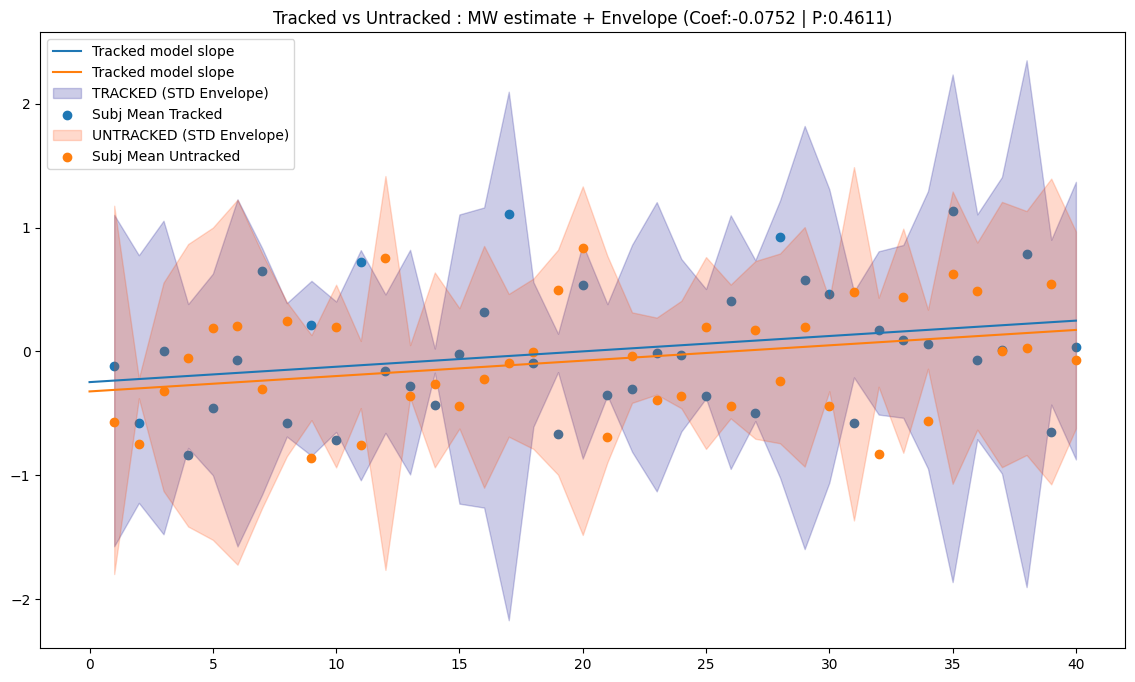

In [ ]:
### Current Subject Specfic Checks: 
# 1)






import statsmodels.formula.api as smf

m = smf.mixedlm("MW_Estimate ~ Tracking+ trialNum ", data=partiaclCheck0[['DS','trialNum','Tracking','MW_Estimate']],
                groups="DS",          # random intercept
               # re_formula="~Tracking",         # adds random slope

               ).fit()
print(m.summary())   


log_file.write("\n===# (1) Uncorrected Samples #=== \n\n")
log_file.write("(1.1) Uncorrected Samples (MW ~ Tracking +TrialNum +(1|Subjects)) \n")

log_file.write(f"      Tracking Effect        (Coef: {m.params[m.params.keys()[1]]:3.3f}| Z: {m.tvalues[m.params.keys()[1]]:3.3f}| P: {m.pvalues[m.params.keys()[1]]:3.3f} | Conf: {m.conf_int().loc[m.params.keys()[1]][0]:3.3f} {m.conf_int().loc[m.params.keys()[1]][1]:3.3f})\n")
log_file.write(f"      Trial Number Effect    (Coef: {m.params[m.params.keys()[2]]:3.3f}| Z: {m.tvalues[m.params.keys()[2]]:3.3f}| P: {m.pvalues[m.params.keys()[2]]:3.3f} | Conf: {m.conf_int().loc[m.params.keys()[2]][0]:3.3f} {m.conf_int().loc[m.params.keys()[2]][1]:3.3f})\n")


fig, ax = plt.subplots(figsize=(14, 8))
plotTrialTrack(m,'MW_Estimate',partiaclCheck0,ax,titl=f"Tracked vs Untracked : MW estimate + Envelope (Coef:{ m.params[m.params.keys()[1]]:1.4f} | P:{ m.pvalues[m.params.keys()[1]]:1.4f})" )
plt.savefig(os.path.join(statPath,f"MWvsUntracked_corr_{est}.png"))

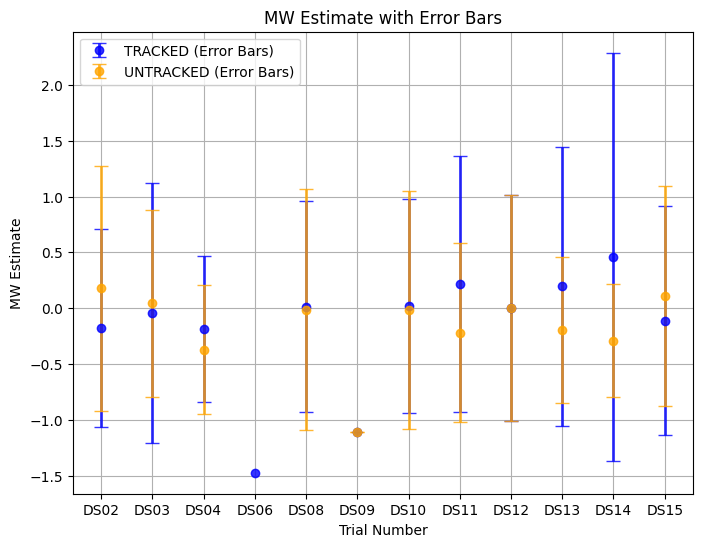

In [ ]:
mew2 = partiaclCheck0[partiaclCheck0['Tracking'] == 'TRACKED'][['DS','MW_Estimate']].groupby(['DS'])
ume2 = partiaclCheck0[partiaclCheck0['Tracking'] == 'UNTRACKED'][['DS','MW_Estimate']].groupby(['DS'])


plt.figure(figsize=(8, 6))

# Plot for TRACKED group
plt.errorbar(mew2.mean().index, 
             mew2.mean()['MW_Estimate'].values, 
             yerr=mew2.std()['MW_Estimate'].values, 
             fmt='o', color='blue', label='TRACKED (Error Bars)', alpha=0.8, 
             capsize=5, elinewidth=2)  # Adjust capsize and line width

# Plot for UNTRACKED group
plt.errorbar(ume2.mean().index, 
             ume2.mean()['MW_Estimate'].values, 
             yerr=ume2.std()['MW_Estimate'].values, 
             fmt='o', color='orange', label='UNTRACKED (Error Bars)', alpha=0.8, 
             capsize=5, elinewidth=2)  # Adjust capsize and line width

# Add labels, legend, and title
plt.xlabel('Trial Number')
plt.ylabel('MW Estimate')
plt.title('MW Estimate with Error Bars')
plt.legend()
plt.grid(True)

# Show the plot
plt.savefig(os.path.join(statPath,"MWacrossSubj_Corr.png"))



======== Test for Pupil Diameter Mean // Left_Eye =======

                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     Pupil      
No. Observations:       322         Method:                 REML       
No. Groups:             12          Scale:                  103518.5835
Min. group size:        1           Log-Likelihood:         -2315.6277 
Max. group size:        40          Converged:              Yes        
Mean group size:        26.8                                           
-----------------------------------------------------------------------
                        Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------
Intercept              -493.553   68.077 -7.250 0.000 -626.981 -360.124
Tracking[T.UNTRACKED]    40.645   35.991  1.129 0.259  -29.896  111.186
trialNum                  3.380    1.587  2.130 0.033    0.270    6.490
DS Var              

c:\Users\barak\Documents\GitHub\startegicMW_lite\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\barak\Documents\GitHub\startegicMW_lite\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


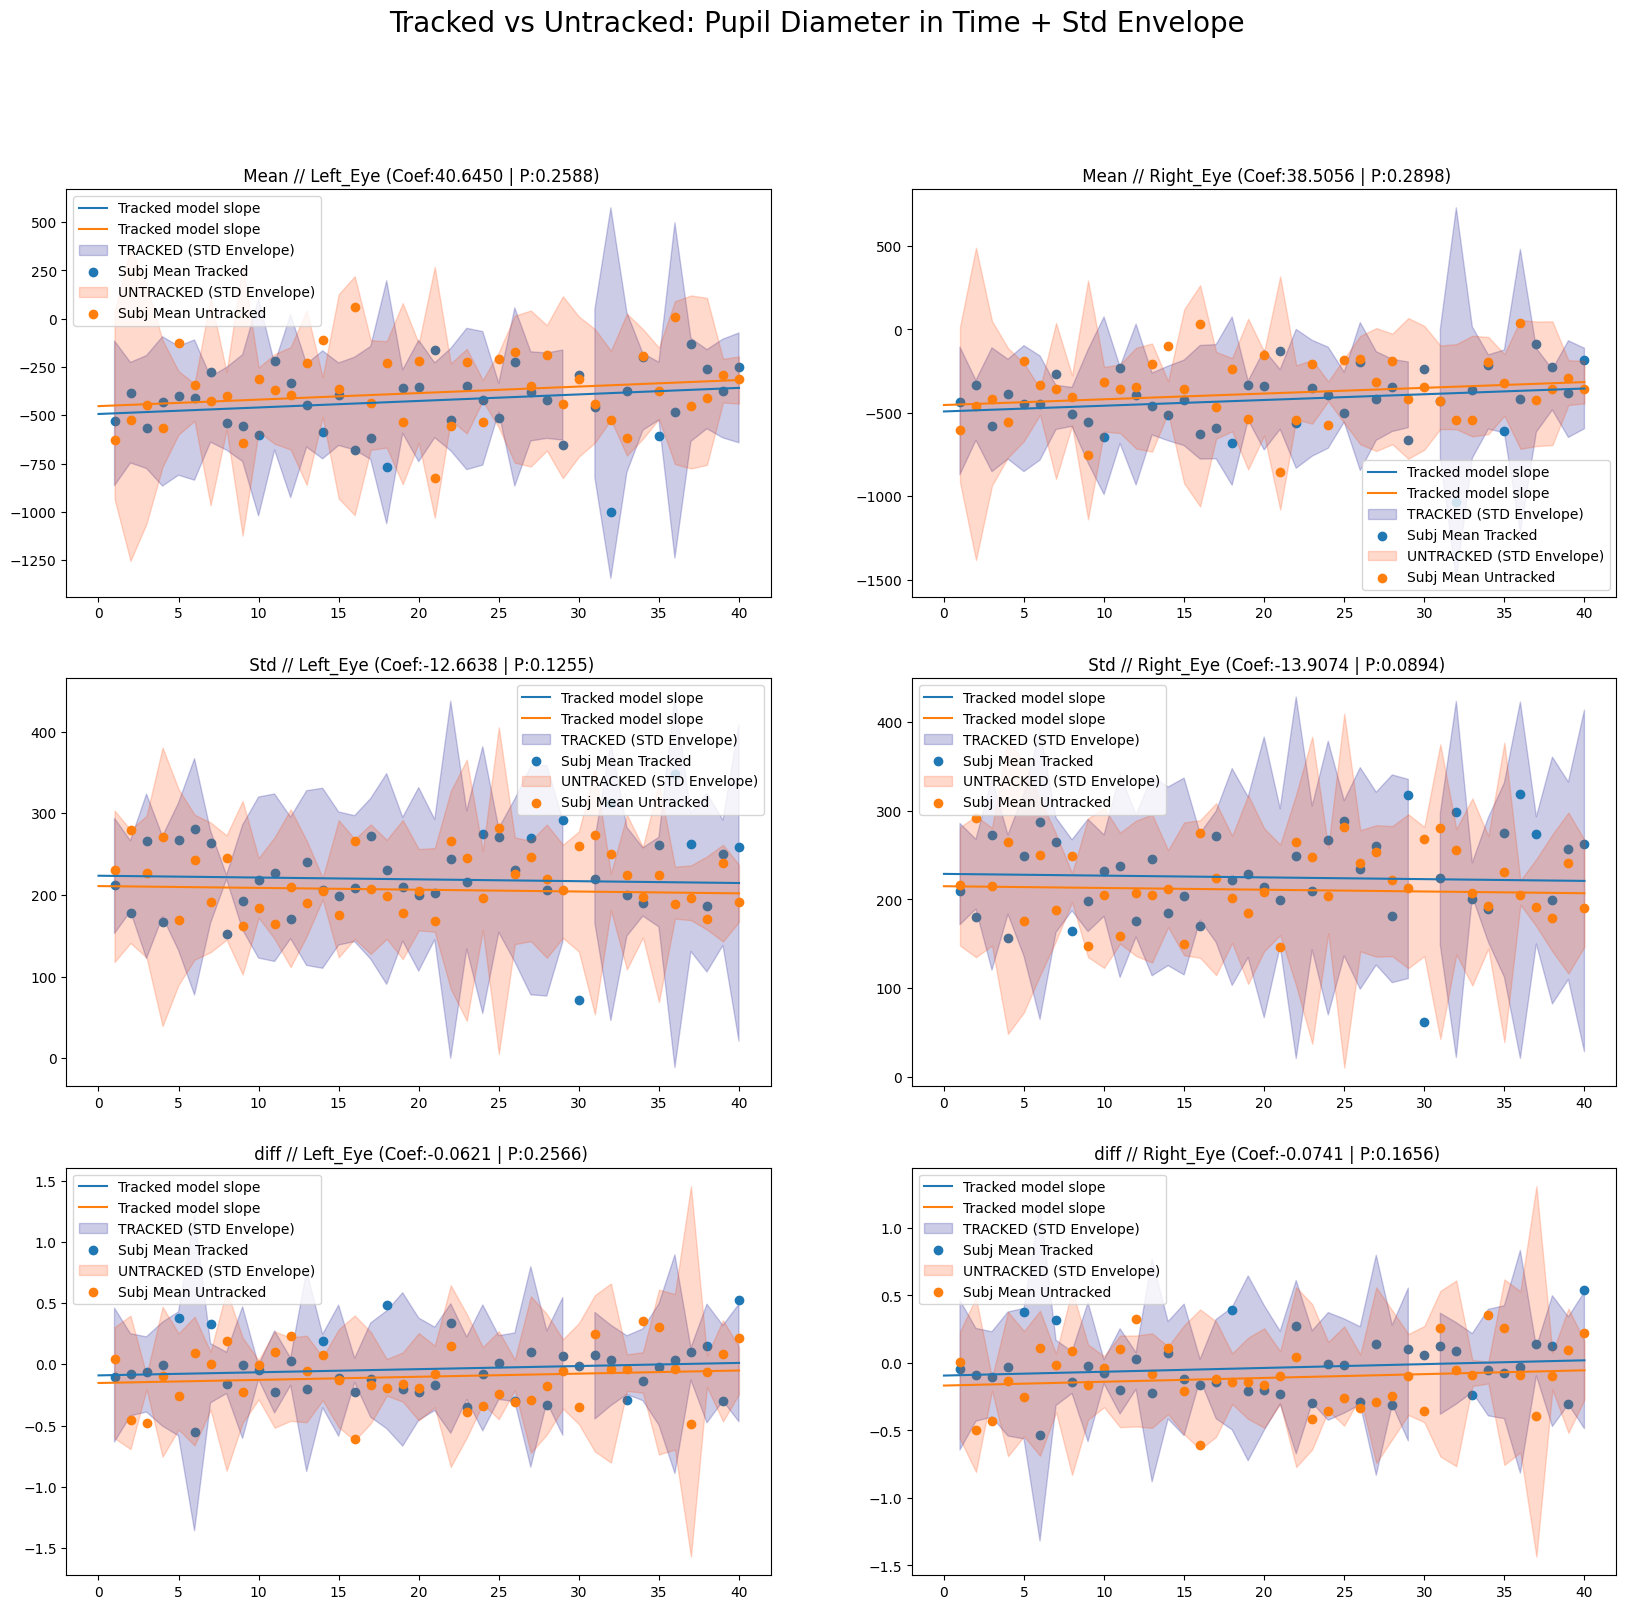

In [ ]:
import statsmodels.formula.api as smf
models = []


fig, axes = plt.subplots(3,2,figsize=(20,18))
fig.suptitle("Tracked vs Untracked: Pupil Diameter in Time + Std Envelope",fontsize=20)
axes = axes.flatten()  # Flatten to easily iterate over axes
log_file.write("\n(1.2) Pupil Diameter vs Tracking (Pupil ~ Tracking +TrialNum +(1|Subjects)) \n")

for i, ind in enumerate(grand_df['Pupil_Diameter'].columns):
    print("\n\n=============================================================")
    print(f"======== Test for Pupil Diameter {ind[0]} // {ind[1]} =======")
    print("=============================================================\n")


    if ind[1] == "Right_Eye":
        currentCheck = partiaclCheck2R;
    else:
        currentCheck = partiaclCheck2L;

    # Create the DataFrame and transpose it
    currentDf = pd.DataFrame([currentCheck['Pupil_Diameter'][ind[0]][ind[1]], currentCheck['DS'], currentCheck['trialNum'], currentCheck['Tracking']]).T
    currentDf.columns = ['Pupil', 'DS', 'trialNum', 'Tracking']
    currentDf['trialNum'] = pd.to_numeric(currentDf['trialNum'], errors='coerce')  # Ensure numeric
    

    # Clean the data
    currentDf = currentDf.dropna(subset=['Pupil', 'Tracking', 'trialNum'])  # Drop rows with NaN
    currentDf['Pupil'] = pd.to_numeric(currentDf['Pupil'], errors='coerce')  # Ensure numeric

    # Fit the mixed effects model
    m = smf.mixedlm("Pupil ~ Tracking + trialNum", data=currentDf,
                    groups="DS",  # Random intercept
                    ).fit()
    
    models.append(m)
    print(m.summary())  # ≈ summary(lm(...)) in R

    
    log_file.write(f"    {ind[0]} // {ind[1]}  \n")

    log_file.write(f"      Tracking Effect        (Coef: {m.params[m.params.keys()[1]]:3.3f}| Z: {m.tvalues[m.params.keys()[1]]:3.3f}| P: {m.pvalues[m.params.keys()[1]]:3.3f} | Conf: {m.conf_int().loc[m.params.keys()[1]][0]:3.3f} {m.conf_int().loc[m.params.keys()[1]][1]:3.3f})\n")
    log_file.write(f"      Trial Number Effect    (Coef: {m.params[m.params.keys()[2]]:3.3f}| Z: {m.tvalues[m.params.keys()[2]]:3.3f}| P: {m.pvalues[m.params.keys()[2]]:3.3f} | Conf: {m.conf_int().loc[m.params.keys()[2]][0]:3.3f} {m.conf_int().loc[m.params.keys()[2]][1]:3.3f})\n")


    plotTrialTrack(m,"Pupil",currentDf,axes[i],titl=f" {ind[0]} // {ind[1]} (Coef:{ m.params[m.params.keys()[1]]:1.4f} | P:{ m.pvalues[m.params.keys()[1]]:1.4f})")

plt.savefig(os.path.join(statPath,"PupilvsTracking_Corr.png" ))



======== Test for Pupil Diameter Mean // Left_Eye =======

                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     Pupil      
No. Observations:       322         Method:                 REML       
No. Groups:             12          Scale:                  105032.7791
Min. group size:        1           Log-Likelihood:         -2315.3410 
Max. group size:        40          Converged:              Yes        
Mean group size:        26.8                                           
-----------------------------------------------------------------------
                        Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------
Intercept              -425.033   59.715 -7.118 0.000 -542.072 -307.994
Tracking[T.UNTRACKED]    42.268   36.246  1.166 0.244  -28.774  113.310
MW_Estimate              -5.871   19.313 -0.304 0.761  -43.724   31.982
DS Var              

c:\Users\barak\Documents\GitHub\startegicMW_lite\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\barak\Documents\GitHub\startegicMW_lite\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


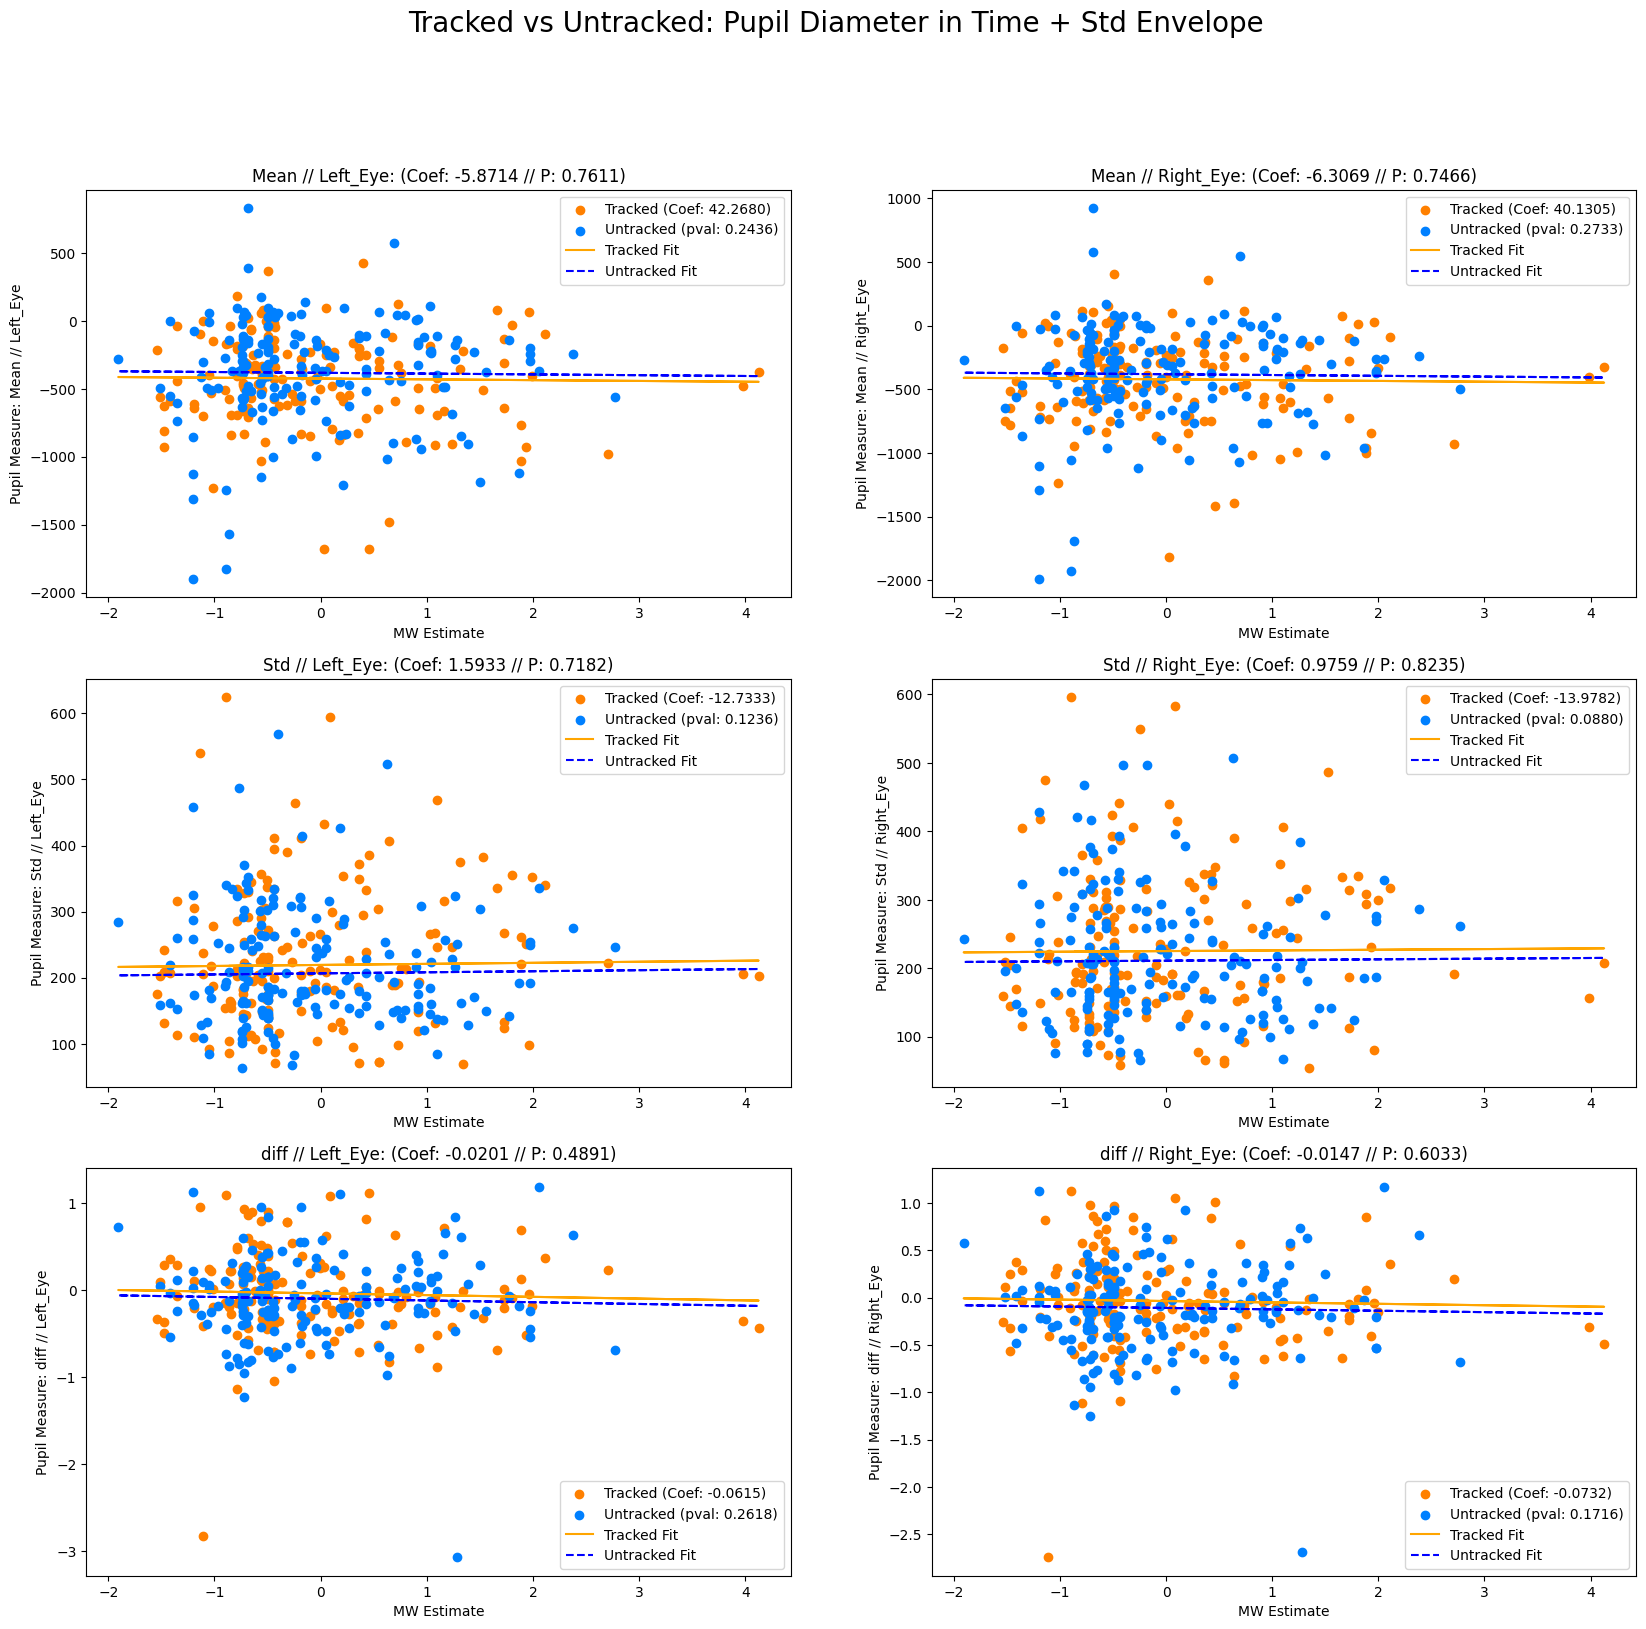

In [ ]:

fig, axes = plt.subplots(3, 2, figsize=(20, 18))  # Adjust rows/columns as needed
fig.suptitle("Tracked vs Untracked: Pupil Diameter in Time + Std Envelope", fontsize=20)
axes = axes.flatten()  # Flatten to easily iterate over axes

log_file.write("\n(1.3) Pupil Diameter vs MW (Pupil ~ MW +Tracking +(1|Subjects)) \n")

for i, ind in enumerate(grand_df['Pupil_Diameter'].columns):
    print("\n\n=============================================================")
    print(f"======== Test for Pupil Diameter {ind[0]} // {ind[1]} =======")
    print("=============================================================\n")


    if ind[1] == "Right_Eye":
        currentCheck = partiaclCheck2R;
    else:
        currentCheck = partiaclCheck2L;

    # Create the DataFrame and transpose it
    currentDf = pd.DataFrame([currentCheck['Pupil_Diameter'][ind[0]][ind[1]], currentCheck['MW_Estimate'], currentCheck['DS'], currentCheck['trialNum'], currentCheck['Tracking']]).T
    currentDf.columns = ['Pupil','MW_Estimate', 'DS', 'trialNum', 'Tracking']

    currentDf['MW_Estimate'] = pd.to_numeric(currentDf['MW_Estimate'], errors='coerce')   # <─ add this
    # Clean the data
    currentDf = currentDf.dropna(subset=['Pupil','MW_Estimate', 'Tracking', 'trialNum'])  # Drop rows with NaN
    currentDf['Pupil'] = pd.to_numeric(currentDf['Pupil'], errors='coerce')  # Ensure numeric
    currentDf['trialNum'] = pd.to_numeric(currentDf['trialNum'], errors='coerce')  # Ensure numeric

    # Fit the mixed effects model
    m = smf.mixedlm("Pupil ~ MW_Estimate + Tracking", data=currentDf,
                    groups="DS",  # Random intercept
                    ).fit()
    
    models.append(m)
     
    log_file.write(f"    {ind[0]} // {ind[1]}  \n")

    log_file.write(f"      Tracking Effect        (Coef: {m.params[m.params.keys()[1]]:3.3f}| Z: {m.tvalues[m.params.keys()[1]]:3.3f}| P: {m.pvalues[m.params.keys()[1]]:3.3f} | Conf: {m.conf_int().loc[m.params.keys()[1]][0]:3.3f} {m.conf_int().loc[m.params.keys()[1]][1]:3.3f})\n")
    log_file.write(f"      MW Estimate Effect     (Coef: {m.params[m.params.keys()[2]]:3.3f}| Z: {m.tvalues[m.params.keys()[2]]:3.3f}| P: {m.pvalues[m.params.keys()[2]]:3.3f} | Conf: {m.conf_int().loc[m.params.keys()[2]][0]:3.3f} {m.conf_int().loc[m.params.keys()[2]][1]:3.3f})\n")

    print(m.summary())  # ≈ summary(lm(...)) in R
    plot_pupil_vs_mw(m, currentDf, ind, ax=axes[i])
plt.savefig(os.path.join(statPath,"PupilvsMW_Corr.png"))

In [ ]:
log_file.close()